In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plotwidth=30

import yaml
with open(r'./WwDec/config.yaml', 'r') as file:
     conf_yaml = yaml.load(file,  Loader=yaml.FullLoader) #dates when to look for some variants

In [2]:
from WwDec.main import *

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import scipy as sp
import re
import similaritymeasures
import glob
from scipy import stats
import zstandard
import os
import glob
import warnings
import matplotlib.dates as mdates
import datetime
import numpy as np
from matplotlib.ticker import StrMethodFormatter
# from scipy.special import kl_div

In [14]:
#input data (from command line)
path_list = ["../work-illumina/","../work-Aviti_30556_long/", "../work-ont_31108_MinION/",
             "../work-ont_31108_Flongle/"]
# #reference sample (Illumina, needs to be first in list)
label_list = ['Illumina','30556_Aviti','31108_MinION','31108_Flongle']

In [15]:
#sometimes have tallymut.tsv instead of tallymut.tsv.zst
file_list = [glob.glob(p + "v-pipe/variants/tallymut.tsv*") for p in path_list]
#flatten list, makes it easier later
file_list = [item for sublist in file_list for item in sublist]
file_list_cov = [p + "v-pipe/AmpCov/amplicons_coverages.csv" for p in path_list]
file_list_cov_norm = [p + "v-pipe/AmpCov/amplicons_coverages_norm.csv" for p in path_list]

primer_bed_file = '../work-ont_31108_MinION_GridION/v-pipe/references/primers/v41/SARS-CoV-2.primer.bed'

#batch definition for spike-in experiments
batch_dic = {'illumina_31441':'batch1',
            'flongle_31583':'batch1',
             'minION_31442':'batch1',
             'illumina_31519':'batch2',
            'flongle_31584':'batch2',
             'minION_31520':'batch2',
             'illumina_31581':'batch3',
            'flongle_31585':'batch3',
             'minION_31582':'batch3',
             'aviti_31441':'batch1',
             'aviti_31519':'batch2',
             'aviti_31581':'batch3'
             }

# batch_dic = {'illumina_31441':'batch1',
#             'flongle_31583_raw':'batch1',
#              'minION_31442_raw':'batch1',
#              'illumina_31519':'batch2',
#             'flongle_31584_raw':'batch2',
#              'minION_31520_raw':'batch2',
#              'illumina_31581':'batch3',
#             'flongle_31585_raw':'batch3',
#              'minION_31582_raw':'batch3'
#              }

batch1 = ['illumina_31441', 'flongle_31583','minION_31442', 'aviti_31441']
batch2 = ['illumina_31519', 'flongle_31584','minION_31520', 'aviti_31519']
batch3 = ['illumina_31581', 'flongle_31585','minION_31582', 'aviti_31581']

# batch1 = ['illumina_31441', 'flongle_31583_raw','minION_31442_raw']
# batch2 = ['illumina_31519', 'flongle_31584_raw','minION_31520_raw']
# batch3 = ['illumina_31581', 'flongle_31585_raw','minION_31582_raw']

dir_spike = '/cluster/work/bewi/members/anjohn/projects/wastewater/spike-in'
dir_out = '/cluster/work/bewi/members/anjohn/projects/wastewater/scripts/analysis/Spike-in'


#joined all sequencing_summary.txt files from spike-in sequencing runs.
#sequencing_summary.txt files are guppy outputs
f_seq_summary = "/cluster/work/bewi/members/anjohn/projects/wastewater/spike-in/flongle_sequencing_summary.txt.gz"
m_seq_summary = "/cluster/work/bewi/members/anjohn/projects/wastewater/spike-in/MinION_sequencing_summary.txt.gz"

out_dir = (
    "./PublicationFigures_final/"
)
variants_list = [
    "B.1.1.7",
    "B.1.351",
    "P.1",
    "B.1.617.2",
    "B.1.617.1",
    "BA.1",
    "BA.2",
    "BA.4",
    "BA.5",
    "BA.2.75",
    #"BA.2.75.2",
    "BQ.1.1"
]
variants_pangolin = {
    "al": "B.1.1.7",
    "be": "B.1.351",
    "ga": "P.1",
    "C36": "C.36.3",
    "ka": "B.1.617.1",
    "de": "B.1.617.2",
    "AY42": "AY.4.2",
    "B16173": "B.1.617.3",
    "om1": "BA.1",
    "om2": "BA.2",
    "om4": "BA.4",
    "om5": "BA.5",
    "om275": "BA.2.75",
    "om2752": "BA.2.75.2",
    "ombq11": "BQ.1.1",
    "om2121": "BA.2.12.1",
}
variants_not_reported = [
    "BA.2.75.2",
    "BA.2.12.1",
    "phe-BA.1",
    "phe-BA.2",
    "C.36.3",
    "B.1.617.3",
    "AY.4.2",
    "mu",
    "d614g",
]
start_date = "2020-12-08"
to_drop = ["subset", "shared"]
cities_list = [
    "Lugano (TI)",
    "Zürich (ZH)",
    "Chur (GR)",
    "Altenrhein (SG)",
    "Laupen (BE)",
    "Genève (GE)",
    "Basel (catchment area ARA Basel)",
#    "Lausanne (VD)",
#    "Kanton Zürich",
]

In [16]:
if not os.path.exists(out_dir):
    # Create the folder
    os.makedirs(out_dir)
    print(f"Folder '{out_dir}' created successfully.")
else:
    print(f"Folder '{out_dir}' already exists.")

Folder './PublicationFigures_final/' already exists.


In [17]:
# import yaml
# with open(r'./WwDec/config.yaml', 'r') as file:
#     conf_yaml = yaml.load(file,  Loader=yaml.FullLoader) #dates when to look for some variants

In [18]:
def sampel_digest(full_string,group):
    regex_pattern = r"([A-Z]\d)_(\d{2})_(\d{4}_\d{2}_\d{2})"
    match = re.search(regex_pattern, full_string)
    return(match[group])

plant_dic = {5.0:"Lugano (TI)",10.0:"Zürich (ZH)",9.0:"Locarno (TI)",12.0:"Lausanne (VD)",13.0:"Lenzburg (AG)",14.0:"Bern (BE)",15.0:"Basel (BS)",
            16.0:"Genève (GE)",17.0:"Chur (GR)",18.0:"Luzern (LU)",19.0:"Altenrhein (SG)", 20.0:"Schaffhausen (SH)", 21.0:"Freienbach (SZ)",
            22.0:"Fribourg (FR)",23.0:"Ergolz (BL)",24.0:"Ski-resort",25.0:"Laupen (BE)",99.0:"water negative"}


def tally_preprocessing(tally_data):

    df_tally = pd.read_csv(tally_data, sep="\t")
    df_tally = df_tally.drop("proto", axis = "columns")

    if ((df_tally['sample'].isnull().values.all()) and ('sample.1' in df_tally.columns)):
        df_tally = df_tally.drop("sample", axis = "columns")
        df_tally = df_tally.rename(columns={"sample.1": "sample"})
    elif ((df_tally['sample'].isnull().values.all()) and ('sample.1' not in df_tally.columns)):
        print('Could not find sample information')
    else:
        pass

    if ((df_tally['date'].isnull().values.all()) and (df_tally['sample'].isnull().values.all() == False)):
        df_tally['date']= df_tally['sample'].map(lambda x: sampel_digest(x,3))
        df_tally["date"]=pd.to_datetime(df_tally['date'], format='%Y%m%d')
    elif ((df_tally['date'].isnull().values.all()) and ('sample' not in df_tally.columns)):
        print('Could not find date information')
    else:
        pass

    if ((df_tally['location_code'].isnull().values.all()) and (df_tally['sample'].isnull().values.any() == False)):
        df_tally['location_code']= df_tally['sample'].map(lambda x: sampel_digest(x,2))
        df_tally['location_code']=df_tally['location_code'].astype("float")
    elif ((df_tally['location_code'].isnull().values.any()) and ('sample' not in df_tally.columns)):
        print('Could not find location_code information')
    else:
        pass

    if ((df_tally['location'].isnull().values.all()) and (df_tally['location_code'].isnull().values.all() == False)):
        df_tally['location'] = df_tally['location_code'].map(lambda x: plant_dic[x])
    elif ((df_tally['location'].isnull().values.any()) and ('location_code' not in df_tally.columns)):
        print('Could not find location information')
    else:
        pass

    if ((df_tally['batch'].isnull().values.all()) and ('batch.1' in df_tally.columns)):
        df_tally = df_tally.drop("batch", axis = "columns")
        df_tally = df_tally.rename(columns={"batch.1": "batch"})
        df_tally['batch'] = df_tally['batch'].astype('object')
    elif ((df_tally['sample'].isnull().values.all()) and ('batch.1' not in df_tally.columns)):
        print('Could not find batch information')
    else:
        pass
    
    df_tally["date"]=pd.to_datetime(df_tally['date'])
    
    #work-around cause pos 21995 has an error in the definitions in v-pipe
    df_tally=df_tally.drop_duplicates()
    
    return df_tally


# %%time

def deconv(df_tally, start, end):
    
    #combine preprocessing and deconvolution steps so later use in one fucntion
    #start and end dates to consider = range of ONT data
    
    #PREPROCESSING
    preproc_tally = DataPreprocesser(df_tally)
    preproc_tally = preproc_tally.general_preprocess(
    variants_list=variants_list,
    variants_pangolin=variants_pangolin,
    variants_not_reported=variants_not_reported,
    to_drop=["subset"],
    start_date=start,
    end_date = end,
    remove_deletions=True,)
    
    #DECONVOLUTION
    np.random.seed(42)
    linear_deconv = []

    for city in tqdm(cities_list): # loop over locatipns
        print(city)
        temp_dfb = preproc_tally.df_tally[preproc_tally.df_tally["location"] == city]
        for idx, mindate in enumerate(list(conf_yaml["var_dates"].keys())): #loop over dates
            temp_df2 = temp_dfb[temp_dfb.date >= mindate]
            if idx < len(conf_yaml["var_dates"]) - 1: 
                temp_df2 = temp_df2[temp_df2.date < list(conf_yaml["var_dates"].keys())[idx+1]]
            if temp_df2.size == 0:
                continue

            t_kdec = KernelDeconv( #objet/class 
                temp_df2[conf_yaml["var_dates"][mindate] + ["undetermined"]],
#                 temp_df2.filter(regex=r'^frac'),
                temp_df2["frac"],
                temp_df2["date"],
                kernel=GaussianKernel(0.01),
                reg=NnlsReg(),
                confint=NullConfint()
            )
            t_kdec = t_kdec.deconv_all(min_tol=1e-1) #hack to have no convelution
            res = t_kdec.renormalize().fitted #extract fitted values
            res["city"] = city
            linear_deconv.append(res)
    linear_deconv_df = pd.concat(linear_deconv)
    linear_deconv_df = linear_deconv_df.fillna(0)

    #LONG FORMAT (for plotting later)
    linear_deconv_df.reset_index(inplace=True)
    linear_deconv_df = linear_deconv_df.rename(columns = {'index':'Date'})
    
    variants = conf_yaml["var_dates"][mindate] + ["undetermined"]
    linear_deconv_dfLong = pd.melt(linear_deconv_df, id_vars=['Date','city'],
        value_vars= variants)

    return [linear_deconv_df,linear_deconv_dfLong]


#function to make dfs for plot
def plotDFs(df_tally_merged, sample_lable):
    cov = df_tally_merged[["pos","cov" +"_"+ sample_lable]].groupby(["pos"]).mean()
    cov.reset_index(inplace=True)
#     df_tally_merged["date"]=df_tally_merged["date"].dt.date
    hm_frac = df_tally_merged.pivot_table(index = ["location","date"],
                                         columns ="pos", 
                                         values = "frac" +"_"+ sample_lable)
    return [cov, hm_frac]

def plotDFs_ampCov(df_cov, sample_lable):
#     cov = pd.read_table(df_cov, sep=",")
#     cov_norm = pd.read_table(df_cov_norm, sep=",")
    
    cov_long = df_cov.melt(id_vars="sample", var_name="amplicon")
#     cov_norm_long = cov_norm.melt(id_vars="sample", var_name="amplicon")
    
    cov_long["tech"] = sample_lable
#     cov_norm_long["tech"] = sample_lable
    
    return cov_long

In [19]:
#function below is from https://github.com/dr-david/amplicon_cov/blob/master/amplicon_covs.py

def load_bedfile(bed="articV3primers.bed"):
    '''function to load a bed file of primers'''
    bedfile = pd.read_table(bed, header=None)
    bedfile["sense"] = [re.search("(LEFT|RIGHT)",i).group(1) for i in bedfile[3]]
    bedfile["primer_num"] = [int(re.search("_([0-9]+)_",i).group(1)) for i in bedfile[3]]
    bedfile["pool"] = [int(re.search("([1-2])$",i).group(1)) for i in bedfile[4].astype("str")]
    bedfile = bedfile[[re.search("alt", i) is None for i in bedfile[3]]]
    # bedfile["alt"] = [re.search("(_alt[0-9]+)", i).group(1) if re.search("(_alt[0-9]+)", i) is not None else " " for i in bedfile[3]]
    # bedfile["primer_code"] = bedfile["primer_num"].astype(str) + bedfile["alt"]
    return bedfile

def make_amplicons_df(bedfile):
    '''function to collapse loaded bedfile into a list of amplicons with start and stop positions of primers, sequences and query'''
    amplicons = []
    for i in np.unique(bedfile["primer_num"]):
        pr_num = i
        seq_start = bedfile[(bedfile["primer_num"] == pr_num) & (bedfile["sense"] == "LEFT")][2].values[0]
        primer_start = bedfile[(bedfile["primer_num"] == pr_num) & (bedfile["sense"] == "LEFT")][1].values[0]
        seq_end = bedfile[(bedfile["primer_num"] == pr_num) & (bedfile["sense"] == "RIGHT")][1].values[0]
        primer_end = bedfile[(bedfile["primer_num"] == pr_num) & (bedfile["sense"] == "RIGHT")][2].values[0]
        pool = bedfile[bedfile["primer_num"] == pr_num]["pool"].values[1]
        
        amplicons.append([pool, pr_num, primer_start, seq_start, seq_end, primer_end])

    amplicons_df = pd.DataFrame(np.array(amplicons),
                                columns=["pool", "primer_num", "primer_start", "seq_start", "seq_end", "primer_end"])
    
    # make query_start and query_stop
    q_starts = []
    q_stops = []
    for i in range(amplicons_df.shape[0]):
        if i>0:
            query_start = amplicons_df.iloc[i-1]["primer_end"] + 5
        else:
            query_start = amplicons_df.iloc[i]["primer_start"]
        
        if i < amplicons_df.shape[0]-1:
            query_stop = amplicons_df.iloc[i+1]["primer_start"] - 5
        else:
            query_stop = amplicons_df.iloc[i]["seq_end"]
            
        q_starts.append(query_start)
        q_stops.append(query_stop)

    amplicons_df["query_start"] = q_starts
    amplicons_df["query_end"] = q_stops

    return amplicons_df


In [20]:
df_tallys = [tally_preprocessing(file_path) for file_path in file_list]

/scratch/tmp.50670906.anjohn/ipykernel_177116/3056030649.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tally = pd.read_csv(tally_data, sep="\t")


In [21]:
#CALCULATE DECONVOLUTIONS
start_ont = pd.to_datetime(df_tallys[1].date).min()
end_ont = pd.to_datetime(df_tallys[1].date).max()

deconv_dfs = [deconv(df_tally,start_ont,end_ont) for df_tally in df_tallys]

  0%|          | 0/7 [00:00<?, ?it/s]

Lugano (TI)
Zürich (ZH)
Chur (GR)
Altenrhein (SG)
Laupen (BE)
Genève (GE)
Basel (catchment area ARA Basel)


  0%|          | 0/7 [00:00<?, ?it/s]

Lugano (TI)
Zürich (ZH)
Chur (GR)
Altenrhein (SG)
Laupen (BE)
Genève (GE)
Basel (catchment area ARA Basel)


  0%|          | 0/7 [00:00<?, ?it/s]

Lugano (TI)
Zürich (ZH)
Chur (GR)
Altenrhein (SG)
Laupen (BE)
Genève (GE)
Basel (catchment area ARA Basel)


  0%|          | 0/7 [00:00<?, ?it/s]

Lugano (TI)
Zürich (ZH)
Chur (GR)
Altenrhein (SG)
Laupen (BE)
Genève (GE)
Basel (catchment area ARA Basel)


In [22]:
#MERGE DECONVOLUTIONS 
for i in range(len(deconv_dfs)):
    deconv_dfs[i][1]['value' + '_'+ label_list[i]] = deconv_dfs[i][1]['value']
    deconv_dfs[i][1] = deconv_dfs[i][1].drop(['value'], axis=1)


linear_deconv_merge = deconv_dfs[0][1]
for i in range(1,len(deconv_dfs)):
    #can do this inner join, without introducing a bias
    #for a certain time frame it is defined which variants are looked for
    #a not dtectable variant will get value = 0
    linear_deconv_merge = linear_deconv_merge.merge(deconv_dfs[i][1], 
                                         on = ['Date','city', 'variable'])
    
linear_deconv_merge =linear_deconv_merge.rename(columns={'variable':'variant'})

In [23]:
linear_deconv_mergeLong = pd.melt(linear_deconv_merge, id_vars=['Date','city',"variant"],
        value_vars=['value_' + item for item in label_list])

linear_deconv_mergeLong=linear_deconv_mergeLong.rename(columns = {'variable':'sequencer',
                                                                  "value":"variant proportion"})

In [24]:
#MERGING DF_TALLYS
# List of columns to exclude from suffix addition
excluded_columns = ['sample', 'pos', 'gene', 'base','ka', 'ga', 'de', 'al', 'be','om1', 'om2', 'om4', 'om5', 'om2121', 'om275', 'om2752', 'ombq11','omxbb','location','date']

#rename tallys, suffix for each sample
for i in range(len(df_tallys)):
    suffix = '_'+ label_list[i]
    new_columns = [col + suffix if col not in excluded_columns else col for col in df_tallys[i].columns]
    df_tallys[i] = df_tallys[i].rename(columns=dict(zip(df_tallys[i].columns, new_columns)))

df_tally_merge = df_tallys[0]
for i in range(1,len(df_tallys)):
    df_tally_merge = df_tally_merge.merge(df_tallys[i], 
                                         on = excluded_columns)


In [25]:
#DFs for the plots
plot_dfs = [plotDFs(df_tally_merge,label) for label in label_list]


In [ ]:
#DFs for Amplicon coverage plots 
df_covs = [pd.read_table(file_path, sep=",") for file_path in file_list_cov]
#this is the realtive coverage, aka  what fractions of read (or read pairs) align to amplicon xy
#ideally it should be 1/98, i.e. uniform, which is what the dotted line shows
df_covs_norm = [pd.read_table(file_path, sep=",") for file_path in file_list_cov_norm]

AmpCov_dfs = [plotDFs_ampCov(df_cov, sample_lable) for df_cov, sample_lable in zip(df_covs,label_list)]
AmpCovNorm_dfs = [plotDFs_ampCov(df_covs_norm, sample_lable) for df_covs_norm, sample_lable in zip(df_covs_norm,label_list)]

AmpCov_dfs_all = pd.concat(AmpCov_dfs)
AmpCovNorm_dfs_all = pd.concat(AmpCovNorm_dfs)

In [ ]:
#normalise coverage
# def cov_log(df,lable):
#     df["covLog" +"_"+ lable] = df['cov' + '_' + label_list[i]].apply(
#     lambda x: np.log10(x) if x > 0 else 0)
#     return df

for label in label_list:
    df_tally_merge["covLog" +"_"+ label] = df_tally_merge['cov' + '_' + label].apply(
    lambda x: np.log10(x) if x > 0 else 0)

In [ ]:
amplicons_df = make_amplicons_df(load_bedfile(primer_bed_file))

t = df_tallys[0].pos.unique()

value_to_primer = {}

# Iterate through each value in t
for val in t:
    matching_rows = amplicons_df[(val >= amplicons_df['seq_start']) & (val <= amplicons_df['seq_end'])]
    primer_nums = matching_rows['primer_num'].tolist()
    
    # If there are matching primer_nums, assign them to the value
    if primer_nums:
        value_to_primer[val] = primer_nums
    
    else:
        value_to_primer[val] = 'NA'

## Spike-in data prep

In [18]:
batches = [batch1, batch2, batch3]

#below this value the an abundance estimation (fraction) is considerd as noise
detec_cutoff = 0.0001 #0.01%, lowest Omicron concentration is 1.1% (recalculated percentages)

In [19]:
#only directories that have order number are sample directories
# dir_all = [name for name in os.listdir(dir_spike) if os.path.isdir(os.path.join(dir_spike, name))]
# dir_samples = [directory for directory in dir_all if directory[-5:].isdigit()]
dir_samples = [item for items in batches for item in items]

#abundance table location
fil_deconvs = [dir_spike + '/'+ s +'/v-pipe/variants/deconvoluted.tsv.zst'for s in dir_samples]
fil_tally = [dir_spike + '/'+ s +'/v-pipe/variants/tallymut.tsv.zst' for s in dir_samples]
fil_cov = [dir_spike + '/'+ s +'/v-pipe/AmpCov/amplicons_coverages.csv' for s in dir_samples]
fil_cov_norm = [dir_spike + '/'+ s +'/v-pipe/AmpCov/amplicons_coverages_norm.csv' for s in dir_samples]

lables = [path.split('spike-in/')[1].split('/v-pipe')[0] for path in fil_deconvs]

#### Data Prep for Error rate analysis

In [20]:
# Define a function to check if a path belongs to a batch
def path_belongs_to_batch(path, batch):
    return any(item in path for item in batch[0])

# Use map to filter paths based on batches
batch1_paths = [dir_spike + '/'+ s +'/v-pipe/variants/tallymut.tsv.zst' for s in batch1]
batch2_paths = [dir_spike + '/'+ s +'/v-pipe/variants/tallymut.tsv.zst' for s in batch2]
batch3_paths = [dir_spike + '/'+ s +'/v-pipe/variants/tallymut.tsv.zst' for s in batch3]

batch1_Deconv_paths = [dir_spike + '/'+ s +'/v-pipe/variants/deconvoluted.tsv.zst' for s in batch1]
batch2_Deconv_paths = [dir_spike + '/'+ s +'/v-pipe/variants/deconvoluted.tsv.zst' for s in batch2]
batch3_Deconv_paths = [dir_spike + '/'+ s +'/v-pipe/variants/deconvoluted.tsv.zst' for s in batch3]

In [21]:
excluded_columns = ['sample', 'pos', 'gene', 'base','ka', 'ga', 'de', 'al', 'be','om1', 'om2', 'om4', 'om5', 'om2121', 'om275', 'om2752', 'ombq11','omxbb','date']

#needed later for error rate estimation, split up at this stage because lazy

#BATCH 1
df_tallys_batch1 = [pd.read_csv(file_path, sep="\t") for file_path in batch1_paths]
#one position is duplicated in v-pipe output
df_tallys_batch1 = [df.drop_duplicates() for df in df_tallys_batch1]


#rename tallys, suffix for each sample
for i in range(len(df_tallys_batch1)):
    suffix = '_'+ batch1[i]
    new_columns = [col + suffix if col not in excluded_columns else col for col in df_tallys_batch1[i].columns]
    df_tallys_batch1[i] = df_tallys_batch1[i].rename(columns=dict(zip(df_tallys_batch1[i].columns, new_columns)))
    
df_tally_merge_batch1 = df_tallys_batch1[0]
for i in range(1,len(df_tallys_batch1)):
    df_tally_merge_batch1 = df_tally_merge_batch1.merge(df_tallys_batch1[i], 
                                         on = excluded_columns)

#BATCH 2
df_tallys_batch2 = [pd.read_csv(file_path, sep="\t") for file_path in batch2_paths]
#one position is duplicated in v-pipe output
df_tallys_batch2 = [df.drop_duplicates() for df in df_tallys_batch2]


#rename tallys, suffix for each sample
for i in range(len(df_tallys_batch2)):
    suffix = '_'+ batch2[i]
    new_columns = [col + suffix if col not in excluded_columns else col for col in df_tallys_batch2[i].columns]
    df_tallys_batch2[i] = df_tallys_batch2[i].rename(columns=dict(zip(df_tallys_batch2[i].columns, new_columns)))
    
df_tally_merge_batch2 = df_tallys_batch2[0]
for i in range(1,len(df_tallys_batch2)):
    df_tally_merge_batch2 = df_tally_merge_batch2.merge(df_tallys_batch2[i], 
                                         on = excluded_columns)

#BATCH 3
df_tallys_batch3 = [pd.read_csv(file_path, sep="\t") for file_path in batch3_paths]

#one position is duplicated in v-pipe output
df_tallys_batch3 = [df.drop_duplicates() for df in df_tallys_batch3]

#rename tallys, suffix for each sample
for i in range(len(df_tallys_batch3)):
    suffix = '_'+ batch3[i]
    new_columns = [col + suffix if col not in excluded_columns else col for col in df_tallys_batch3[i].columns]
    df_tallys_batch3[i] = df_tallys_batch3[i].rename(columns=dict(zip(df_tallys_batch3[i].columns, new_columns)))
    
df_tally_merge_batch3 = df_tallys_batch3[0]
for i in range(1,len(df_tallys_batch3)):
    df_tally_merge_batch3 = df_tally_merge_batch3.merge(df_tallys_batch3[i], 
                                         on = excluded_columns)
    
#need a merge of all batches for coverage per position later
merge_columns = ['sample', 'pos', 'gene', 'base','ka', 'ga', 'de', 'al', 'be','om1', 'om2', 'om4', 'om5', 'om2121', 'om275', 'om2752', 'ombq11','omxbb']

tally_batches = list([df_tally_merge_batch1,df_tally_merge_batch2,df_tally_merge_batch3])

df_tally_merge_spike = tally_batches[0]

for i in range(1,len(tally_batches)):
    df_tally_merge_spike = df_tally_merge_spike.merge(tally_batches[i],
                                                     on=merge_columns)

In [22]:
#merging deconvolution data frames by batch 
def merge_SpikeDeconv_dfs(deconv_dfs_path, sample_names):
    
    df_deconvs = [pd.read_csv(file_path, sep="\t") for file_path in deconv_dfs_path]
    df_deconvs_long = [pd.melt(df, id_vars=['location']) for df in df_deconvs]


    for i in range(len(df_deconvs_long)):
        tech = sample_names[i].split('_')[0]
        df_deconvs_long[i]['value' + '_'+ tech] = df_deconvs_long[i]['value']
        df_deconvs_long[i] = df_deconvs_long[i].drop(['value'], axis=1)

    linear_deconv_merge = df_deconvs_long[0]

    for i in range(1,len(df_deconvs_long)):
        linear_deconv_merge = linear_deconv_merge.merge(df_deconvs_long[i], 
                                         on = ['location', 'variable'])

    linear_deconv_merge =linear_deconv_merge.rename(columns={'variable':'variant'})
    
    return linear_deconv_merge

#calculate error rate from non-diluted spike-in samples
def make_error_df(df_tally_merge):
    
    df_error = df_tally_merge
    df_error = df_error.fillna(0)
    df_error = df_error.replace('mut', 1)
    df_error = df_error.replace('shared', 1)
    
    #only regard BA.1 specific mutations
    df_error.loc[(df_error['al'] == 0) & 
                (df_error['be'] == 0) & 
                (df_error['ga'] == 0) & 
                (df_error['de'] == 0) &
                (df_error['ka'] == 0) &
                (df_error['om1'] == 1)&
                (df_error['om2'] == 0)&
                (df_error['om275'] == 0)&
                (df_error['om2752'] == 0)&
                (df_error['om2121'] == 0)&
                (df_error['omxbb'] == 0)&
                (df_error['ombq11'] == 0)&
                (df_error['om4'] == 0)&
                (df_error['om5'] == 0), 'variant'] = 'Om1'

    df_error = df_error.loc[(df_error['sample']== 1) &
                (df_error['variant']== 'Om1')]
    
    selected_columns = ['pos'] + df_error.columns[df_error.columns.str.startswith('frac')].tolist()

    
    df_error = df_error[selected_columns]
    df_error_long = pd.melt(df_error, 
                           id_vars=['pos'], 
                           var_name='sample',
                           value_name='fraction')
    df_error_long['Error rate'] = 1-df_error_long['fraction']
    
    df_error_long['Tech'] = df_error_long['sample'].str.split('_').str[1]
    df_error_long['sample_number'] = df_error_long['sample'].str.split('_').str[2]
    
    return df_error_long



In [23]:
#long format
filter_col = ['pos']+[col for col in df_tally_merge_spike if col.startswith('cov')]

#when calcualting error rate, only look at undiluted sample
df = df_tally_merge_spike.loc[df_tally_merge_spike['sample'] == 1]
df = df[filter_col]

df_tally_mergeLong_spike = pd.melt(df, id_vars = ['pos'],
                                   value_name = 'cov',
                                  var_name = 'sample')
df_tally_mergeLong_spike['sample'] = df_tally_mergeLong_spike['sample'].str.removeprefix("cov_")

In [24]:
deconv_batch1 = merge_SpikeDeconv_dfs(batch1_Deconv_paths,batch1)
deconv_batch2 = merge_SpikeDeconv_dfs(batch1_Deconv_paths,batch2)
deconv_batch3 = merge_SpikeDeconv_dfs(batch1_Deconv_paths,batch3)

deconv_merge_spike = pd.concat([deconv_batch1,deconv_batch2,deconv_batch3],axis =0)

In [25]:
df_covs_spike = [pd.read_table(file_path, sep=",") for file_path in fil_cov]
#this is the realtive coverage, aka  what fractions of read (or read pairs) align to amplicon xy
#ideally it should be 1/98, i.e. uniform, which is what the dotted line shows
df_covs_norm_spike = [pd.read_table(file_path, sep=",") for file_path in fil_cov_norm]

AmpCov_spike_dfs = [plotDFs_ampCov(df_cov, sample_lable) for df_cov, sample_lable in zip(df_covs_spike,lables)]
AmpCovNorm_spike_dfs = [plotDFs_ampCov(df_covs_norm, sample_lable) for df_covs_norm, sample_lable in zip(df_covs_norm_spike,lables)]

AmpCov_spike_dfs_all = pd.concat(AmpCov_spike_dfs)
AmpCovNorm_spike_dfs_all = pd.concat(AmpCovNorm_spike_dfs)
# AmpCovNorm_spike_dfs_all['Tech'] = AmpCovNorm_spike_dfs_all['tech'].str.split('_').str[0]


In [26]:
#this is the theoretical groundtruth
groundTruth = pd.DataFrame({'location' : list(range(1,13)),
                            'Omicron_perc' : [100, 91.6, 83.3,66.6,58.3,50,25,12.5,6.25,3.125,1.625,0],
                            'Omicron_perc_calibrated' : [100,88.324, 77.469, 57.900,49.05,40.748,18.648,8.945,4.384,2.17,1.078,0],
                            'Omicron_conc': [30,27.5,25,20,17.5,15,7.5,3.75,1.875,0.9375,0.6875,0],
                            'background_perc' : [0, 8.4,16.7,33.4,41.7,50,75,87.5,93.75,96.875,98.4375,100]
                           })
groundTruth['Omicron_frac'] = groundTruth['Omicron_perc']/100
groundTruth['Omicron_frac_calibrated'] = groundTruth['Omicron_perc_calibrated']/100

In [27]:
#deconvolution output of v-pipe (version as of July 2023), extremly small bandwidth == no deconvolution
df_deconvs = [pd.read_csv(file_path, sep="\t") for file_path in fil_deconvs]
df_deconvs_long = [pd.melt(df, id_vars=['location']) for df in df_deconvs]

for i in range(len(df_deconvs_long)):
    df_deconvs_long[i]['sample_class'] = re.sub(r'[\d_]+', '', lables[i])
    df_deconvs_long[i]['sample'] = lables[i]

    
df_deconvs_long_bind = pd.concat(df_deconvs_long, axis=0)

In [28]:
#DETERMINE DETECTION LIMITS per sequencing technology
# we do not want to consider samples with a very low abundance estimation e.g. 10-16 as 'detected'. This is 
# likely just noise as it is not even close to the first theorectical abundance of 0.01625. Hence every
# value smaller or equal to the cut off is excluded from the data set an then the first detected value is 
# considered the detction limit of the respective sample/ sequencing technology.

df_threshold = [df.loc[df.value >= detec_cutoff] for df in df_deconvs_long]
df_detectLimit = [df.loc[df.groupby('variable').value.idxmin()] for df in df_threshold]
df_detectLimit_all = pd.concat(df_detectLimit, axis=0)

#only interested in Omicron cause known concentration
detectLimits_flongle = list(df_detectLimit_all.loc[(df_detectLimit_all.variable == 'BA.1') & 
                                                 (df_detectLimit_all.sample_class == 'flongle')].location)
detectLimits_illumina = list(df_detectLimit_all.loc[(df_detectLimit_all.variable == 'BA.1') & 
                                                 (df_detectLimit_all.sample_class == 'illumina')].location)
detectLimits_minION = list(df_detectLimit_all.loc[(df_detectLimit_all.variable == 'BA.1') & 
                                                 (df_detectLimit_all.sample_class == 'minION')].location)

detectLimits = {"flongle": detectLimits_flongle,
               "illumina": detectLimits_illumina,
               "minION":detectLimits_minION}


# Publication Plots

# Real-life surveillance data

In [29]:
sns.set_context("notebook", font_scale=1.5)

In [30]:
AmpCov_dfs_all['amplicon'] = AmpCov_dfs_all.amplicon.astype(int) +1

In [31]:
palette={'Illumina': sns.color_palette()[0],
         '31108_MinION': sns.color_palette()[1],
        '31108_Flongle': sns.color_palette()[2],
         '30556_Aviti': sns.color_palette()[3],
         '30556_G4': sns.color_palette()[4]
        }

paletteB={'Illumina': sns.color_palette()[0],
         'MinION': sns.color_palette()[1],
        'Flongle': sns.color_palette()[2],
         'Aviti': sns.color_palette()[3],
         'G4': sns.color_palette()[4]
        }

/scratch/tmp.50670906.anjohn/ipykernel_137706/4064364382.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticks(), size = 20)
/scratch/tmp.50670906.anjohn/ipykernel_137706/4064364382.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(axes[1].get_yticks(), size = 20)


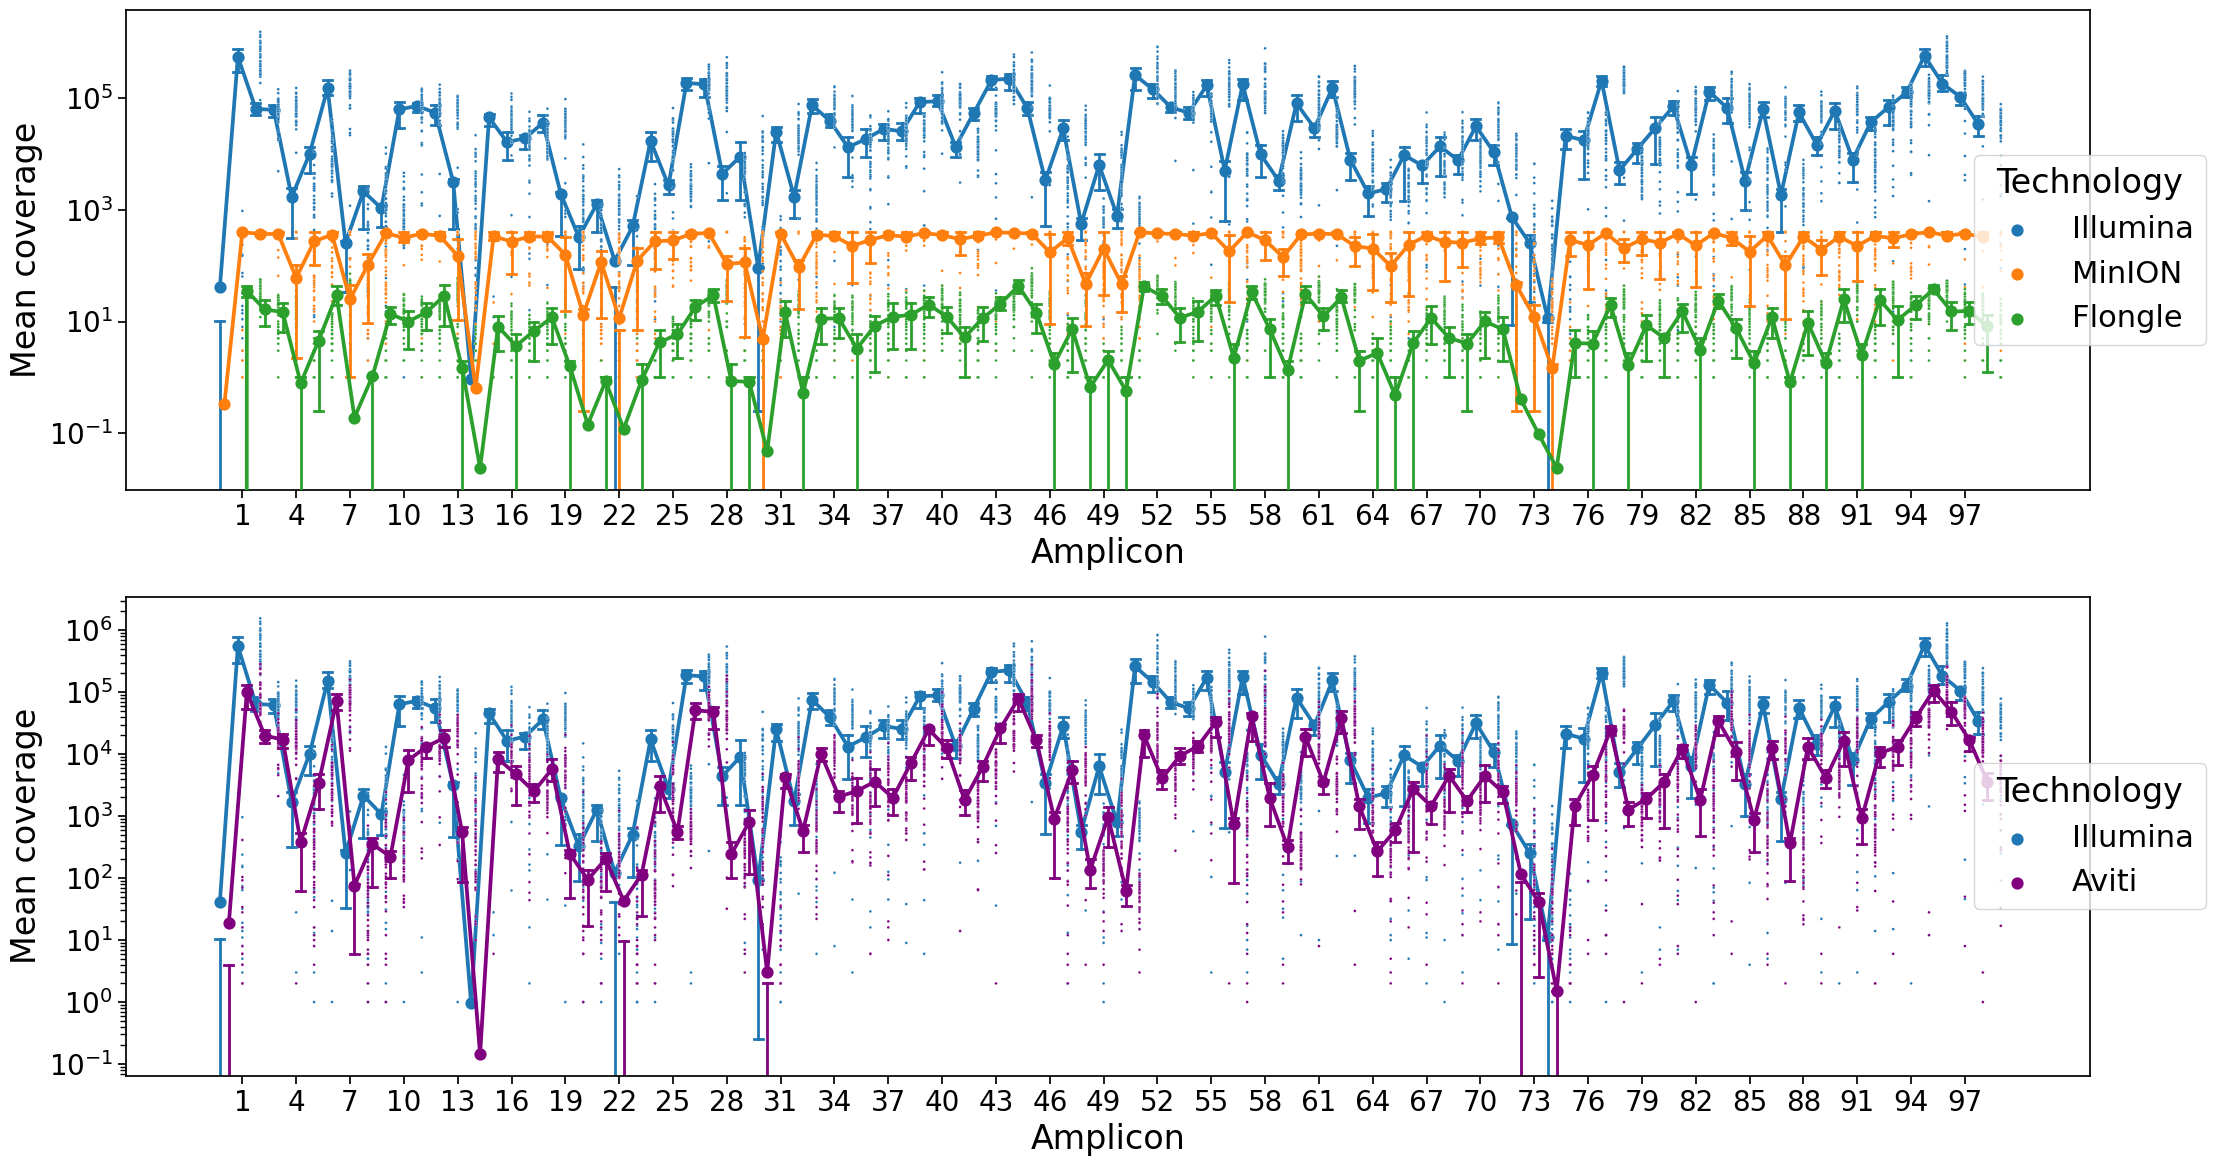

In [32]:
# sns.set_context("notebook", font_scale=1)

fig, axes = plt.subplots(2,1,figsize=(30*0.75, 4*4*0.75)) 

#don't need batch info in dispaly
AmpCov_dfs_all['tech'] = AmpCov_dfs_all['tech'].apply(lambda x: re.sub(r'[0-9]{5}_', '', x))

AmpCov_dfs1 = AmpCov_dfs_all.loc[(AmpCov_dfs_all.tech != 'G4') & 
                   (AmpCov_dfs_all.tech != 'Aviti')]

AmpCov_dfs2 = AmpCov_dfs_all.loc[(AmpCov_dfs_all.tech != 'MinION') & 
                   (AmpCov_dfs_all.tech != 'Flongle')&
                   (AmpCov_dfs_all.tech != 'G4')]

sns.pointplot(
    x=AmpCov_dfs1.amplicon,
    y=AmpCov_dfs1.value,
    hue=AmpCov_dfs1.tech, 
    errorbar=("pi", 50),
    dodge=0.5,
    capsize=0.5,
    errwidth = 2,
    palette = paletteB,
    ax=axes[0]
)


sns.scatterplot(
    x=AmpCov_dfs1.amplicon,
    y=AmpCov_dfs1.value,
    hue=AmpCov_dfs1.tech, 
    s = 4,
    legend=False,
    ax=axes[0]
)

legend = axes[0].legend(title='Technology',
                        loc='center', 
                        bbox_to_anchor=(1, 0.5),
                        fontsize=22,
                        title_fontsize=24)
        
axes[0].set_ylabel("Mean coverage",size=24)
axes[0].set_xlabel("Amplicon",size=24)
axes[0].set_xticks(np.arange(1, 100, 3))
axes[0].set_xticklabels(axes[0].get_xticks(), size = 20)
axes[0].set_yticklabels(axes[0].get_yticks(), size = 20)
axes[0].set_yscale("log")



sns.pointplot(
    x=AmpCov_dfs2.amplicon,
    y=AmpCov_dfs2.value,
    hue=AmpCov_dfs2.tech, 
    errorbar=("pi", 50),
    dodge=0.5,
    capsize=0.5,
    errwidth = 2,
    palette ={'Illumina': "#1f77b4", 'G4': "#ff0000", 'Aviti': '#800080'},
    ax=axes[1]
)


sns.scatterplot(
    x=AmpCov_dfs2.amplicon,
    y=AmpCov_dfs2.value,
    hue=AmpCov_dfs2.tech, 
    s = 4,
    legend=False,
    palette ={'Illumina': "#1f77b4", 'G4': "#ff0000", 'Aviti': '#800080'},
    ax=axes[1]
)

legend = axes[1].legend(title='Technology', 
                        loc='center', 
                        bbox_to_anchor=(1, 0.5),
                        fontsize=22,
                        title_fontsize=24)
        
axes[1].set_ylabel("Mean coverage",size=24)
axes[1].set_xlabel("Amplicon",size=24)
axes[1].set_xticks(np.arange(1, 100, 3))
axes[1].set_xticklabels(axes[1].get_xticks(), size = 20)
axes[1].set_yticklabels(axes[1].get_yticks(), size = 20)
axes[1].set_yscale("log")


fig.tight_layout()
fig.show()
fig.savefig(out_dir + "/AmpliconCoverage.png",dpi=600)

### Theoretical Amplicon Distribution over Genome

### Coverage over genome 
To visualise amplicon coverage better

In [40]:
cov_Illumina = pd.read_table(path_list[0]+'v-pipe/variants/MeanCoverage.csv', sep=',')
cov_aviti = pd.read_table(path_list[1]+'v-pipe/variants/MeanCoverage.csv', sep=',')
cov_minION = pd.read_table(path_list[2]+'v-pipe/variants/MeanCoverage.csv', sep=',')
cov_Flongle = pd.read_table(path_list[3]+'v-pipe/variants/MeanCoverage.csv', sep=',')


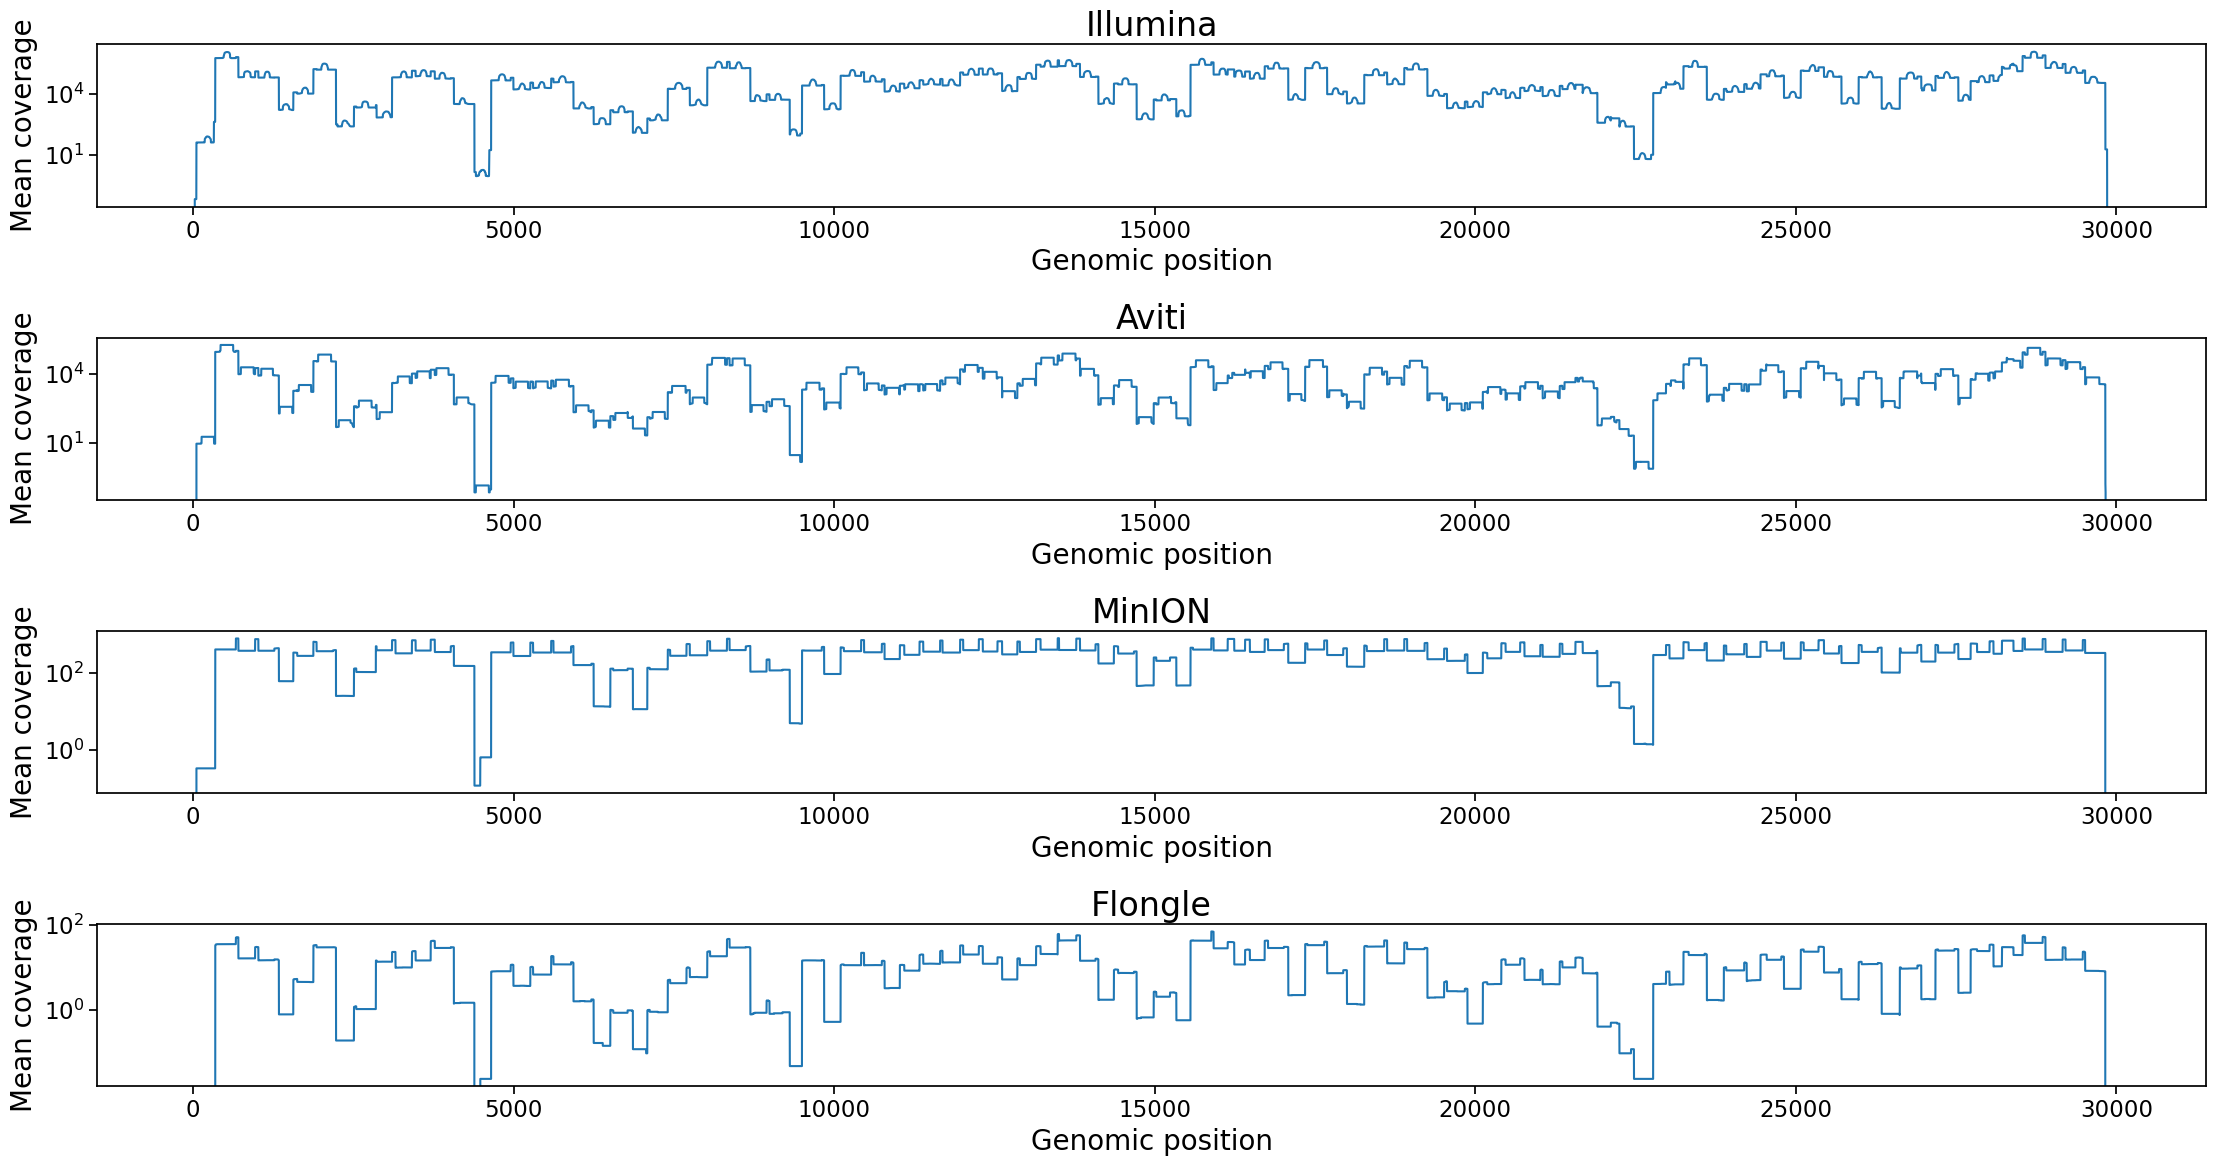

In [41]:
fig, axes = plt.subplots(4,1,figsize=(30*0.75, 4*4*0.75))

sns.lineplot(cov_Illumina, x="pos", y="mean",ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_ylabel("Mean coverage",size=20)
axes[0].set_xlabel("Genomic position",size=20)
axes[0].set_title("Illumina",size=24)

sns.lineplot(cov_aviti, x="pos", y="mean",ax=axes[1])
axes[1].set_yscale("log")
axes[1].set_ylabel("Mean coverage",size=20)
axes[1].set_xlabel("Genomic position",size=20)
axes[1].set_title("Aviti",size=24)

sns.lineplot(cov_minION, x="pos", y="mean",ax=axes[2])
axes[2].set_yscale("log")
axes[2].set_ylabel("Mean coverage",size=20)
axes[2].set_xlabel("Genomic position",size=20)
axes[2].set_title("MinION",size=24)

sns.lineplot(cov_Flongle, x="pos", y="mean",ax=axes[3])
axes[3].set_yscale("log")
axes[3].set_ylabel("Mean coverage",size=20)
axes[3].set_xlabel("Genomic position",size=20)
axes[3].set_title("Flongle",size=24)


fig.tight_layout()
fig.show()
fig.savefig(out_dir + "/PositionalCoverage.png",dpi=600)

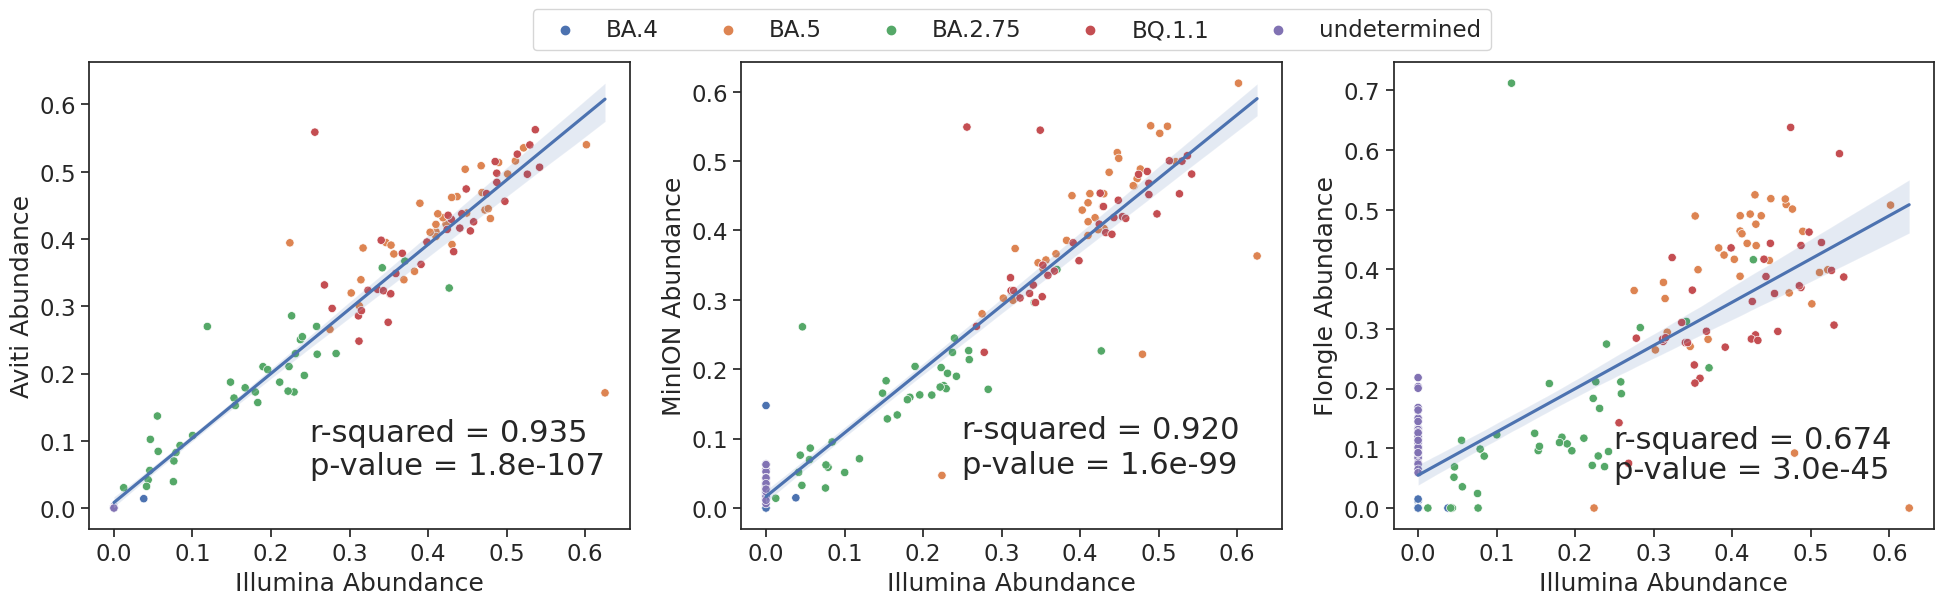

In [84]:
import scipy.stats as sp

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.tight_layout(pad =1.75)
# Initialize the index for label_list
label_index = 0

#don't need batch info dispalyed
lables_clean = [re.sub(r'[0-9]{5}_', '', string) for string in label_list]

# Iterate through the plot_dfs
for i in range(1, len(lables_clean)):
    # Illumina needs to be first in list
    r, p = sp.pearsonr(
        linear_deconv_merge['value' + '_' + label_list[0]],
        linear_deconv_merge['value' + '_' + label_list[i]]
    )
    
    sns.scatterplot(
        data=linear_deconv_merge,
        x='value' + '_' + label_list[0],
        y='value' + '_' + label_list[i],
        hue="variant",
        palette='deep',
        ax=axes[i-1],
        legend=True
    )

    # Add the regression line to the scatter plot
    sns.regplot(
        x='value' + '_' + label_list[0],
        y='value' + '_' + label_list[i],
        data=linear_deconv_merge,
        scatter_kws={"zorder": -1,'alpha':0.001},
#         ax=axes[row, col],
        ax=axes[i-1]
    )

    # Add the text with the correlation coefficient to the subplot
    axes[i-1].text(0.25, 0.1, 'r-squared = {:.3f}'.format(r**2), fontsize=22)
    axes[i-1].text(0.25, 0.05,'p-value = {:.1e}'.format(p), fontsize=22)

    # Set labels for the x and y axes
    axes[i-1].set_xlabel(lables_clean[0] + ' Abundance')
    axes[i-1].set_ylabel(lables_clean[i] + ' Abundance')
    
    handles, labels = axes[i-1].get_legend_handles_labels()
    for dot in handles:
        dot.set_sizes(dot.get_sizes() * 20)
    plt.legend(handles, labels)

    if i == 2:
        sns.move_legend(
            axes[i-1], "lower center",
            bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=True)
        
    else:
        axes[i-1].get_legend().remove()

# fig.savefig(out_dir + "/AbundanceCorrelation.png",dpi=600)

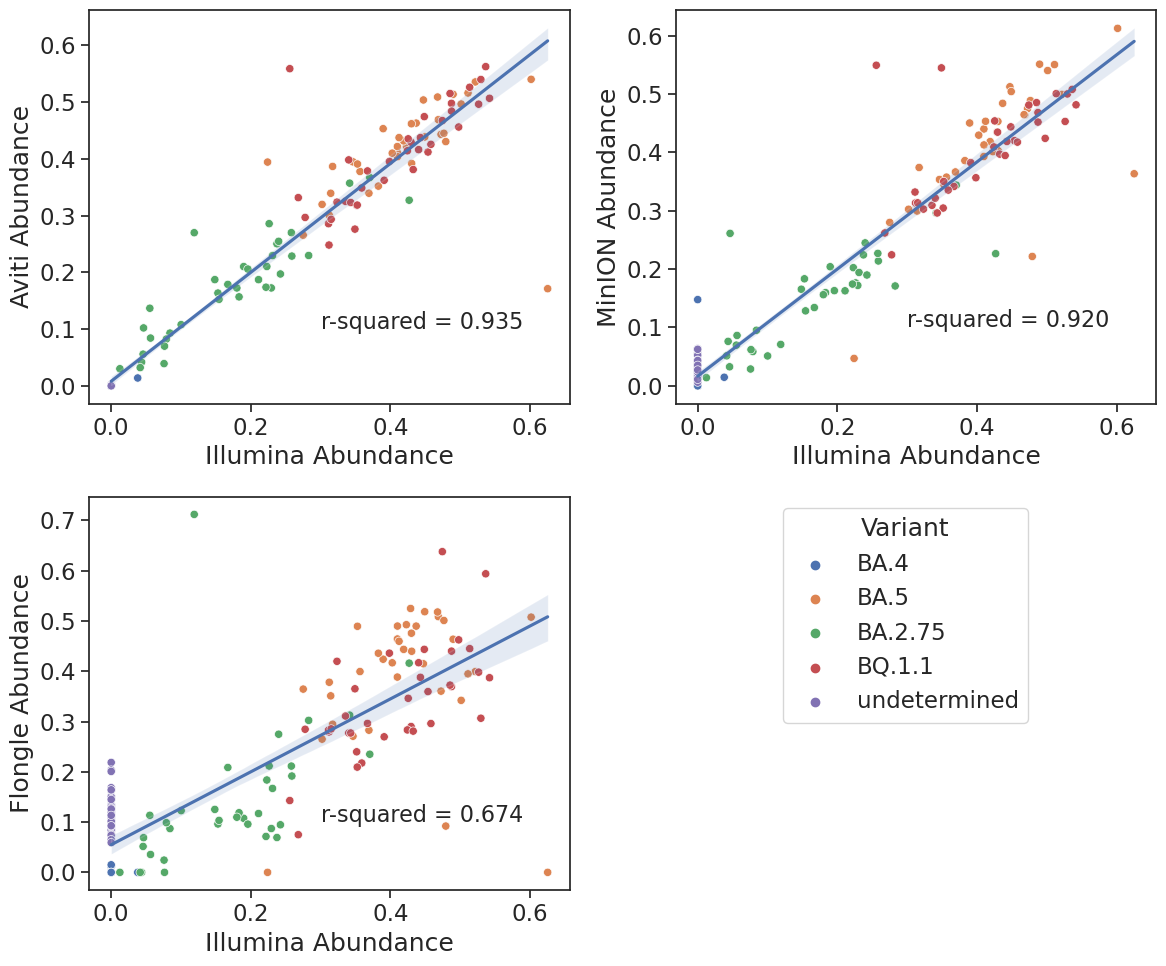

In [85]:
import scipy.stats as sp

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.delaxes(axes[1,1])
# Adjust subplot layout
plt.subplots_adjust(right=4.0, top=1.3)

# Initialize the index for label_list
label_index = 0

#don't need batch info dispalyed
lables_clean = [re.sub(r'[0-9]{5}_', '', string) for string in label_list]

# Iterate through the plot_dfs
for i in range(1, len(lables_clean)):
    # Illumina needs to be first in list
    r, p = sp.pearsonr(
        linear_deconv_merge['value' + '_' + label_list[0]],
        linear_deconv_merge['value' + '_' + label_list[i]]
    )
    
    
    if i == 1:
        row = 0  
        col = 0
        
    elif i == 2:
        row = 0  
        col = 1
    else:
        row = 1  
        col = 0
    # Determine the current subplot's position
#     row = i // 2  # Determine the row position (0 or 1)
#     col = i % 2   # Determine the column position (0 or 1)

    # Create a scatter plot on the current subplot
    
    sns.scatterplot(
        data=linear_deconv_merge,
        x='value' + '_' + label_list[0],
        y='value' + '_' + label_list[i],
        hue="variant",
        palette='deep',
        ax=axes[row, col],
#         ax=axes[i-1],
        legend=True
    )

    # Add the regression line to the scatter plot
    sns.regplot(
        x='value' + '_' + label_list[0],
        y='value' + '_' + label_list[i],
        data=linear_deconv_merge,
        scatter_kws={"zorder": -1,'alpha':0.001},
        ax=axes[row, col],
#         ax=axes[i-1]
    )

    # Add the text with the correlation coefficient to the subplot
    axes[row, col].text(0.3, 0.1, 'r-squared = {:.3f}'.format(r**2), fontsize=16)
#     axes[i-1].text(0.3, 0.1, 'r-squared = {:.3f}'.format(r**2), fontsize=16)

    # Set labels for the x and y axes
    axes[row, col].set_xlabel(lables_clean[0] + ' Abundance')
    axes[row, col].set_ylabel(lables_clean[i] + ' Abundance')
    
#     axes[i-1].set_xlabel(lables_clean[0] + ' Abundance')
#     axes[i-1].set_ylabel(lables_clean[i] + ' Abundance')
    
    if i == 3:
        
        plt.tight_layout()
#         plt.legend(loc="upper center", bbox_to_anchor=(1.35, 1),title='Variant')
        axes[row, col].legend(loc="upper center", bbox_to_anchor=(1.7, 1), title='Variant')
        plt.show()
        
    else:
        plt.tight_layout()
        axes[row, col].get_legend().remove()


fig.savefig(out_dir + "/AbundanceCorrelation.png",dpi=600)

/scratch/tmp.50022044.anjohn/ipykernel_148987/400220372.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  r,p= sp.stats.pearsonr(data[x], data[y])
/cluster/work/bewi/members/anjohn/miniconda3/envs/ww_analysis/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/scratch/tmp.50022044.anjohn/ipykernel_148987/400220372.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  r,p= sp.stats.pearsonr(data[x], data[y])
/cluster/work/bewi/members/anjohn/miniconda3/envs/ww_analysis/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/scratch/tmp

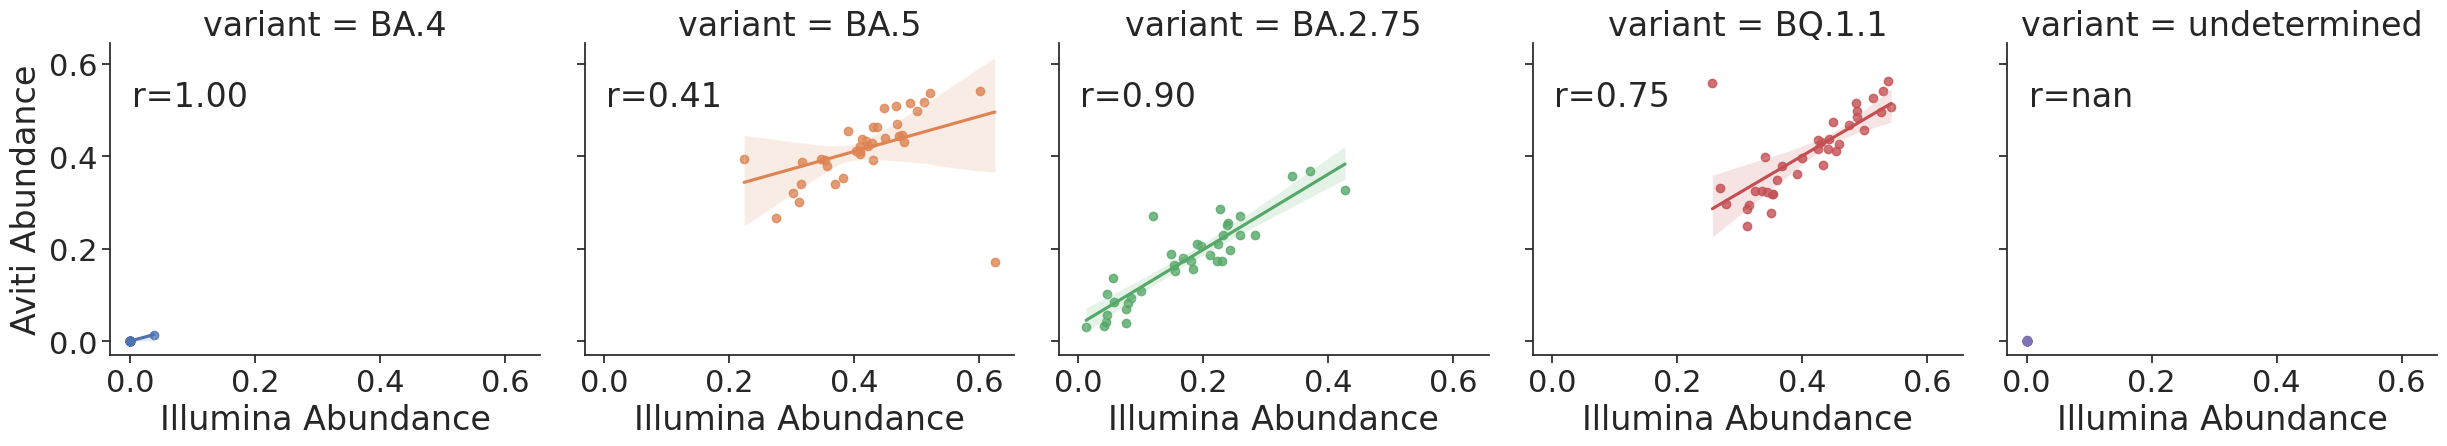

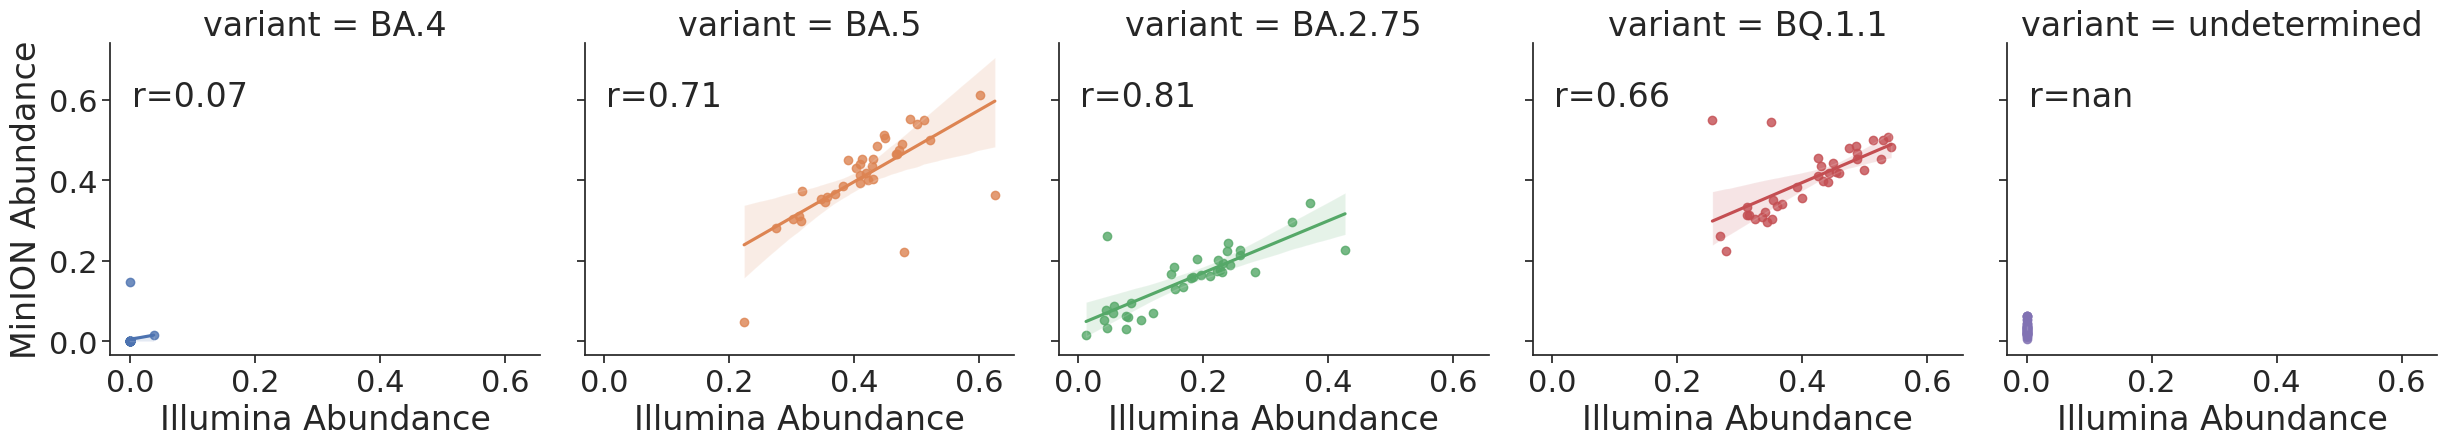

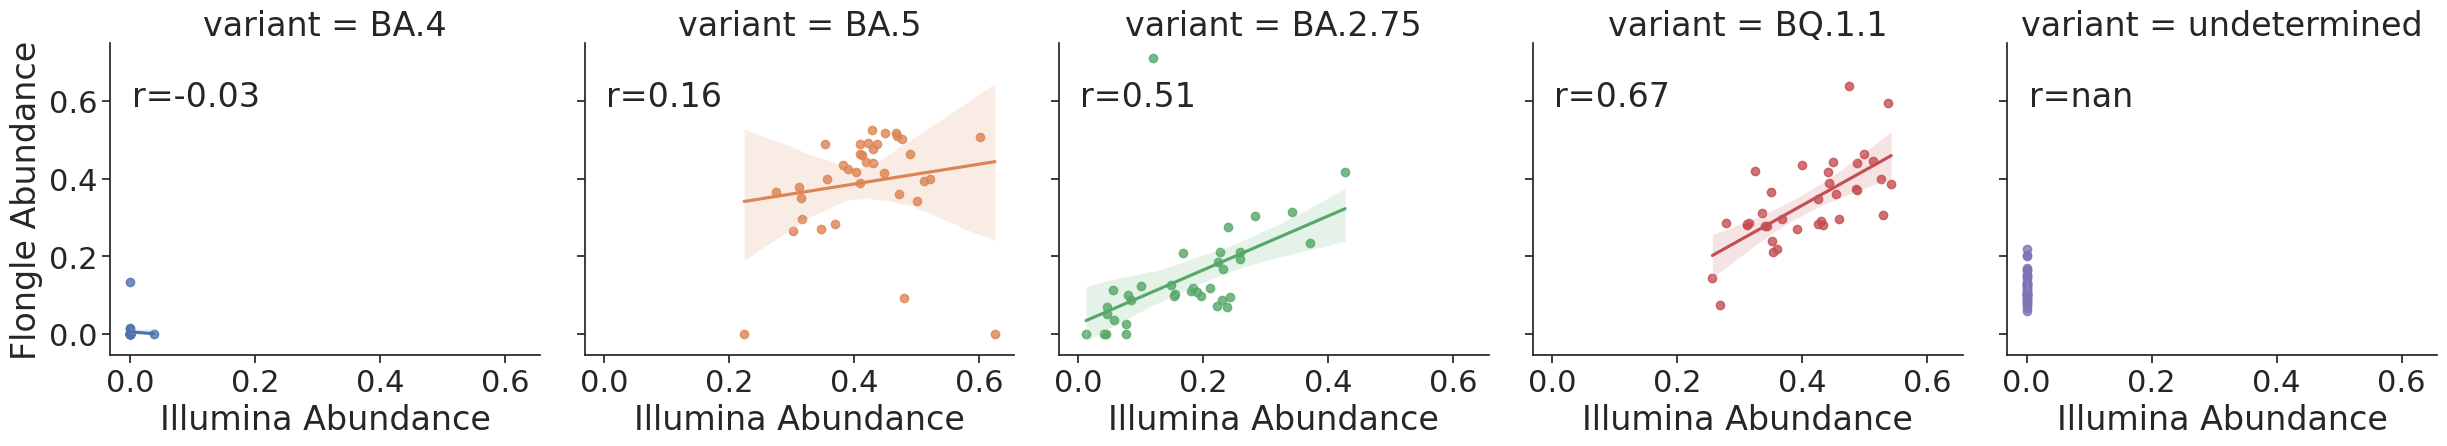

In [86]:
def annotate(data,x, y, **kws):
    r,p= sp.stats.pearsonr(data[x], data[y])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}'.format(r),
            transform=ax.transAxes, size =24)

sns.set_context("notebook", font_scale=2)

for i in range(1,len(plot_dfs)):
    g = sns.lmplot(data=linear_deconv_merge, 
                   x = 'value'+'_'+label_list[0],
                   y = 'value'+'_'+label_list[i],
                   hue = "variant",
                   col = "variant",
                   palette ='deep')
    g.map_dataframe(annotate,
                    x ='value'+'_'+label_list[0],
                    y='value'+'_'+label_list[i])
    g.set_axis_labels(y_var=lables_clean[i] + ' Abundance',size =24)
    g.set_axis_labels(lables_clean[0] + ' Abundance',size =24)
    g.savefig(out_dir+"/Correlation_VariantAbundances_By_Variant_"+lables_clean[i]+".png",
              bbox_inches='tight',dpi=600) 


### Outlier investigation 

In [87]:
df_sample_cov = AmpCov_dfs_all[['sample','tech','value']].groupby(['sample','tech']).mean()
df_sample_cov = df_sample_cov.reset_index()
df_sample_cov['date']= df_sample_cov['sample'].map(lambda x: sampel_digest(x,3))
df_sample_cov['date'] = df_sample_cov['date'].astype(str)
df_sample_cov['location_code']= df_sample_cov['sample'].map(lambda x: sampel_digest(x,2))
df_sample_cov['location_code']=df_sample_cov['location_code'].astype("float")
df_sample_cov['location'] = df_sample_cov['location_code'].map(lambda x: plant_dic[x])
df_sample_cov['city'] = df_sample_cov['location']
df_sample_cov['Date'] = df_sample_cov['date'].map(lambda x: x.replace("_", "-"))
df_sample_cov['Date'] = pd.to_datetime(df_sample_cov['Date'], format="%Y-%m-%d")
df_sample_cov=df_sample_cov.drop(['sample','location_code'],axis=1)
df_sample_cov['covLog_sample'] = df_sample_cov['value'].apply(
    lambda x: np.log10(x) if x > 0 else 0)
df_sample_cov = df_sample_cov.loc[df_sample_cov.tech == 'Illumina'].reset_index()
df_sample_cov = df_sample_cov[['Date','city','covLog_sample']]


In [88]:
deconv_by_IllCov = linear_deconv_merge.merge(df_sample_cov,how='left')

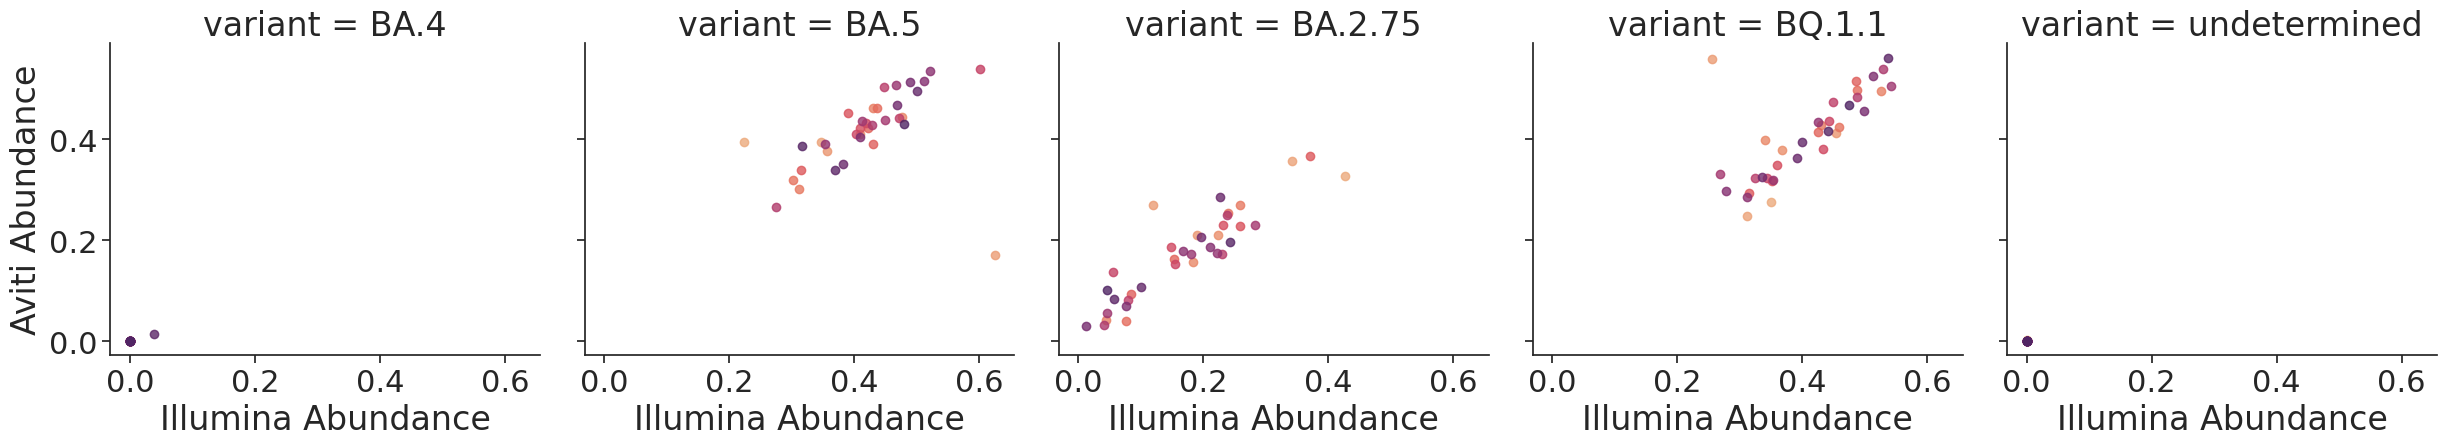

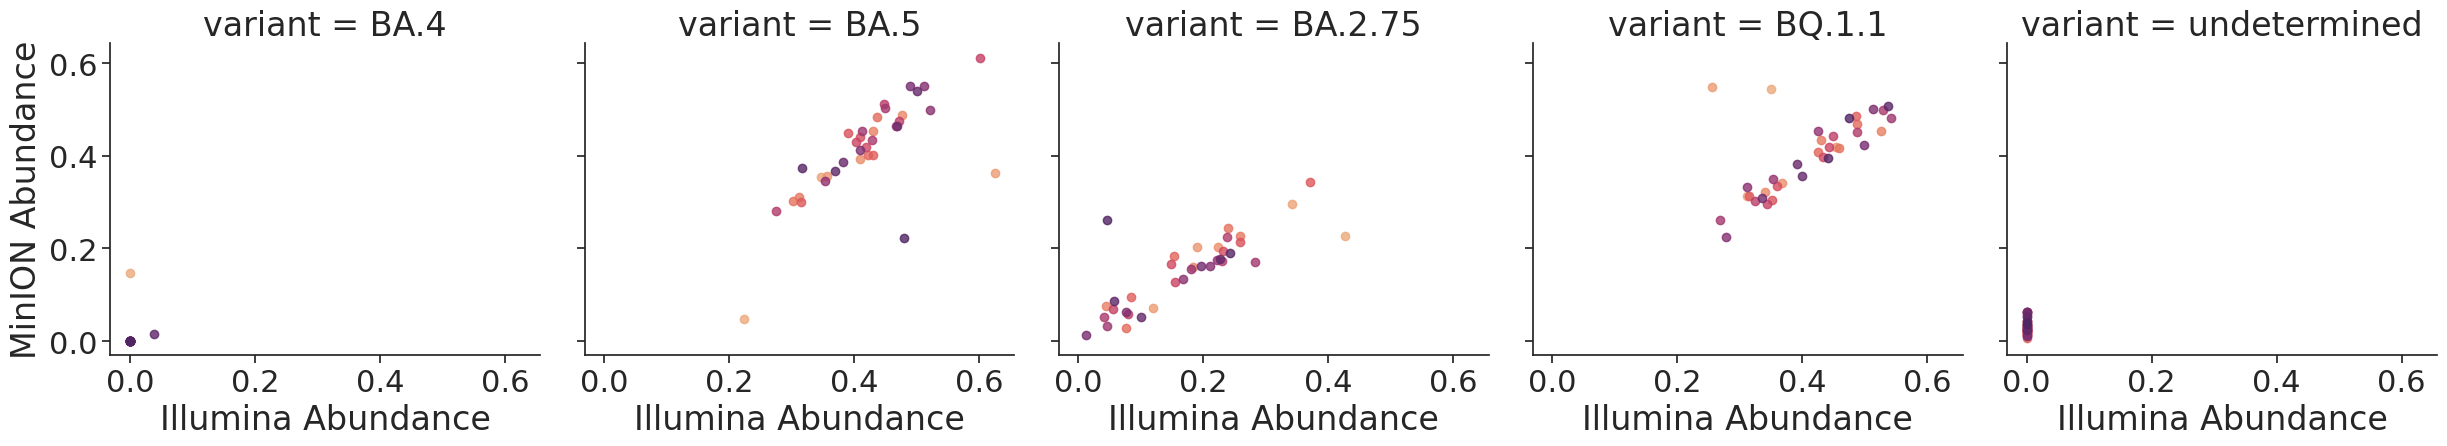

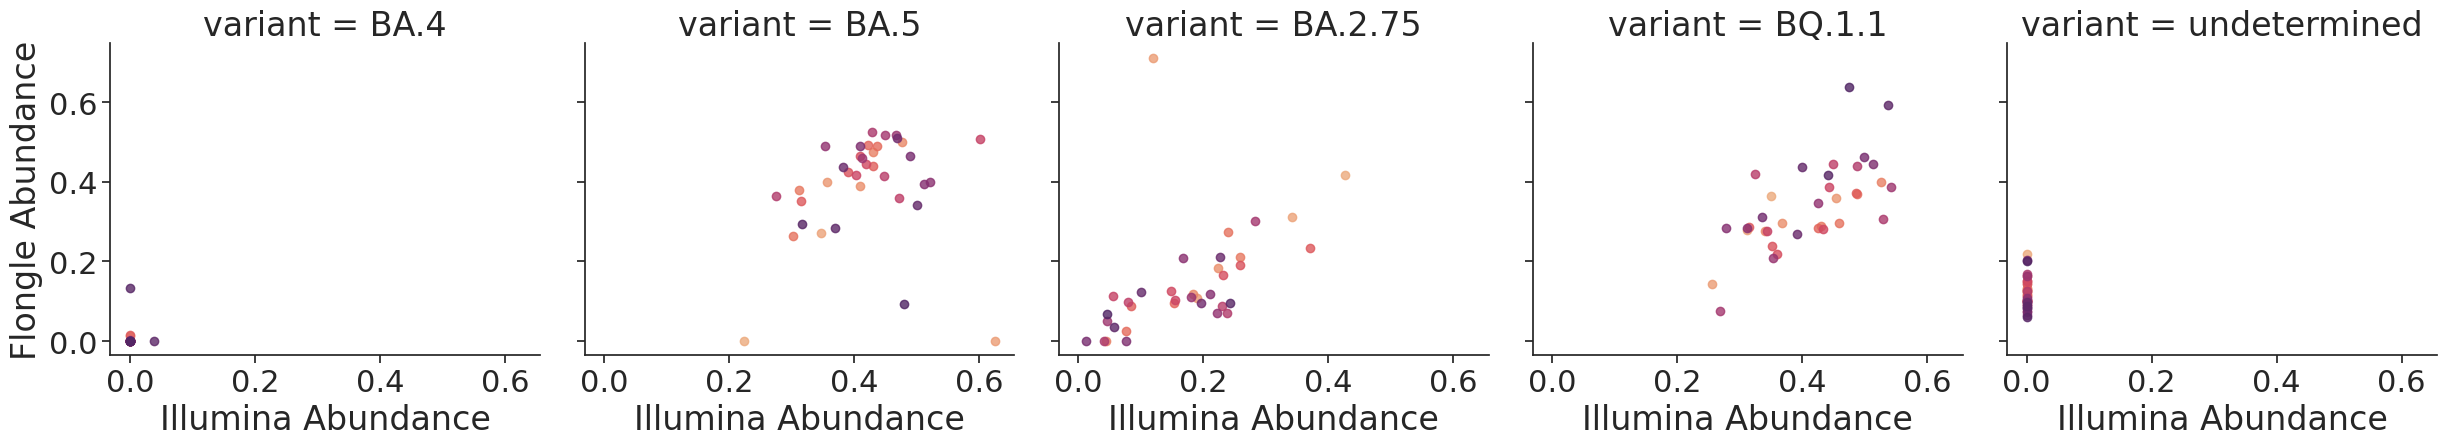

In [89]:
def annotate(data,x, y, **kws):
    r,p= sp.stats.pearsonr(data[x], data[y])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}'.format(r),
            transform=ax.transAxes, size =24)

sns.set_context("notebook", font_scale=2)

for i in range(1,len(plot_dfs)):
    g = sns.lmplot(data=deconv_by_IllCov, 
                   x = 'value'+'_'+label_list[0],
                   y = 'value'+'_'+label_list[i],
                   hue = "covLog_sample",
                   col = "variant",
                   palette = "flare",
                  legend=False)
    g.set_axis_labels(y_var=lables_clean[i] + ' Abundance',size =24)
    g.set_axis_labels(lables_clean[0] + ' Abundance',size =24)
    g.savefig(out_dir+"/VariantAbundances_By_Variant_By_SampleCov_"+lables_clean[i]+".png",
              bbox_inches='tight',dpi=600) 

### Mutation Frequency correlations

Input of LolliPop is muation frequencies of previously defined signature mutations. Here look of the raw input correlates (muation frequencies) and how it is linked to coverage.

In [90]:
df = df_tally_merge.fillna(0)
df = df.replace('mut', 1)
df = df.replace('shared', 1)

In [91]:
#only interested in mutations that describe the observed variants
df[['om4','om5', 'ombq11', 'om275']] = df[['om4','om5', 'ombq11', 'om275']].applymap(lambda x: 1 if isinstance(x, str) else x)
df_filtered = df[(df['om4'] != 0) |(df['om5'] != 0) | (df['ombq11'] != 0) | (df['om275'] != 0)]

In [92]:
df_filtered['variant'] = ''
df_filtered.loc[(df_filtered['om5'] == 0) & 
                (df_filtered['ombq11'] == 0) & 
                (df_filtered['om275'] == 0) &
                (df_filtered['om4'] == 1), 'variant'] = 'Om4'

df_filtered.loc[(df_filtered['om5'] == 0) & 
                (df_filtered['ombq11'] == 0) & 
                (df_filtered['om275'] == 1) &
                (df_filtered['om4'] == 0), 'variant'] = 'Om275'

df_filtered.loc[(df_filtered['om5'] == 1) & 
                (df_filtered['ombq11'] == 0) & 
                (df_filtered['om275'] == 0) & 
                (df_filtered['om4'] == 0), 'variant'] = 'Om5'

df_filtered.loc[(df_filtered['om5'] == 0) & 
                (df_filtered['ombq11'] == 1) & 
                (df_filtered['om275'] == 0) &
                (df_filtered['om4'] == 0), 'variant'] = 'Ombq11'

df_filtered.loc[(df_filtered['om5'] == 1) &
                (df_filtered['ombq11'] == 1) &
                (df_filtered['om275'] == 0) &
                (df_filtered['om4'] == 0), 'variant'] = 'Om5 & Ombq11'


df_filtered.loc[(df_filtered['om5'] == 0) &
                (df_filtered['ombq11'] == 1) &
                (df_filtered['om275'] == 1) &
                (df_filtered['om4'] == 0), 'variant'] = 'Ombq11 & Om275'

df_filtered.loc[(df_filtered['om5'] == 0) &
                (df_filtered['ombq11'] == 0) &
                (df_filtered['om275'] == 1) &
                (df_filtered['om4'] == 1), 'variant'] = 'Om4 & Om275'

df_filtered.loc[(df_filtered['om5'] == 1) &
                (df_filtered['ombq11'] == 0) &
                (df_filtered['om275'] == 1) &
                (df_filtered['om4'] == 0), 'variant'] = 'Om5 & Om275'


df_filtered.loc[(df_filtered['om5'] == 0) &
                (df_filtered['ombq11'] == 1) &
                (df_filtered['om275'] == 0) &
                (df_filtered['om4'] == 1), 'variant'] = 'Om4 & Ombq11'

df_filtered.loc[(df_filtered['om5'] == 0) &
                (df_filtered['ombq11'] == 1) &
                (df_filtered['om275'] == 1) &
                (df_filtered['om4'] == 1), 'variant'] = 'Om4 & Om275 & Ombq11'

df_filtered.loc[(df_filtered['om5'] == 1) &
                (df_filtered['ombq11'] == 0) &
                (df_filtered['om275'] == 1) &
                (df_filtered['om4'] == 1), 'variant'] = 'Om4 & Om5 &'+'\n'+'Omb275'

df_filtered.loc[(df_filtered['om5'] == 1) &
                (df_filtered['ombq11'] == 1) &
                (df_filtered['om275'] == 0) &
                (df_filtered['om4'] == 1), 'variant'] = 'Om4 & Om5 &' +'\n'+ 'Ombq11'


df_filtered.loc[(df_filtered['om5'] == 1) & 
                (df_filtered['ombq11'] == 0) & 
                (df_filtered['om275'] == 0) &
                (df_filtered['om4'] == 1), 'variant'] = 'Om4 & Om5'

df_filtered.loc[(df_filtered['om5'] == 1) &
                (df_filtered['ombq11'] == 1) &
                (df_filtered['om275'] == 1) &
                (df_filtered['om4'] == 0), 'variant'] = 'Om5 & Ombq11' +'\n'+'& Om275'


df_filtered.loc[(df_filtered['om5'] == 1) &
                (df_filtered['ombq11'] == 1) &
                (df_filtered['om275'] == 1) &
                (df_filtered['om4'] == 1), 'variant'] = 'Om4 & Om5 &' +'\n'+'Om275 & Ombq11'


/scratch/tmp.50022044.anjohn/ipykernel_148987/1366203173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['variant'] = ''


In [93]:
continous_palette = sns.color_palette("Blues", as_cmap=True)

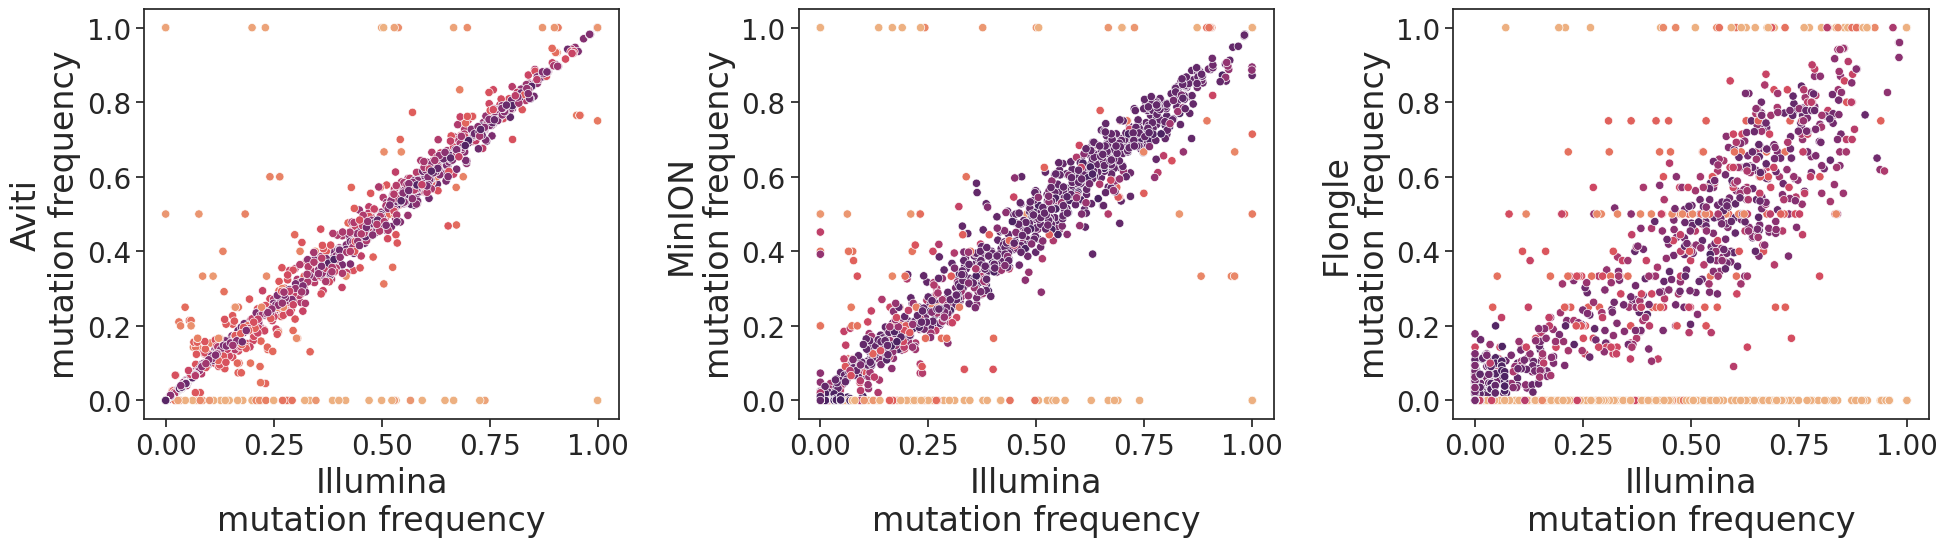

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

df_plot = df_filtered[['frac_Illumina','frac_30556_Aviti','frac_31108_MinION','frac_31108_Flongle','covLog_Illumina',
       'covLog_31108_MinION', 'covLog_31108_Flongle', 'covLog_30556_Aviti','variant']]
df_plot = df_plot[df_plot['variant'].isin(
        ['Om4', 'Om5','Ombq11','Om275'])]

#don't need batch info dispalyed
lables_clean = [re.sub(r'[0-9]{5}_', '', string) for string in label_list]

# Iterate through the plot_dfs
for i in range(1, len(label_list)):
    # Illumina needs to be first in list
   
    sns.scatterplot(
        data=df_plot,
        x='frac' + '_' + label_list[0],
        y='frac' + '_' + label_list[i],
        hue = 'covLog'+'_'+label_list[i],
        palette = "flare",
        ax=axes[i-1],
        legend=False
    )
   
    # Set labels for the x and y axes
    axes[i-1].set_xlabel(lables_clean[0] +'\n'+'mutation'+' frequency', size =24)
    axes[i-1].set_ylabel(lables_clean[i] +'\n'+'mutation'+' frequency', size =24)
    
    axes[i-1].tick_params(axis='both', which='major',labelsize=20)
    
    plt.tight_layout()
    
fig.savefig(out_dir + "/MutFreq.png",dpi=600)

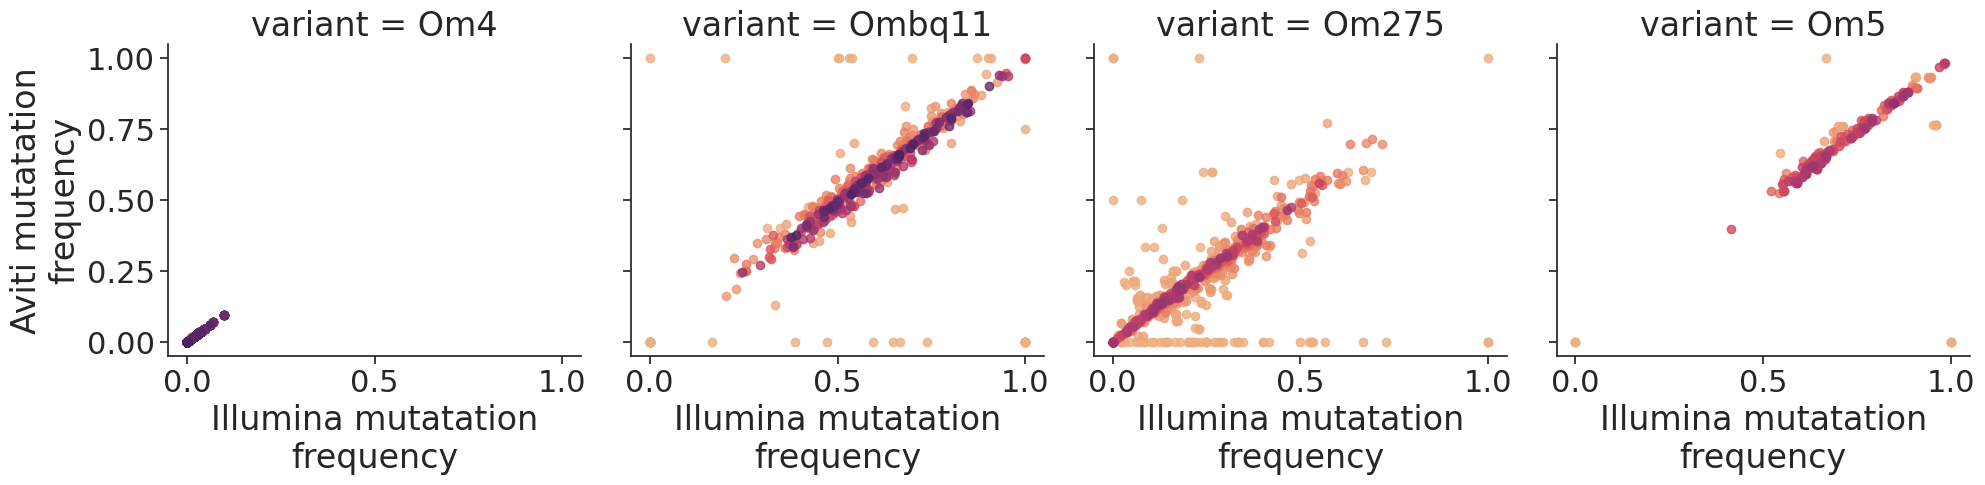

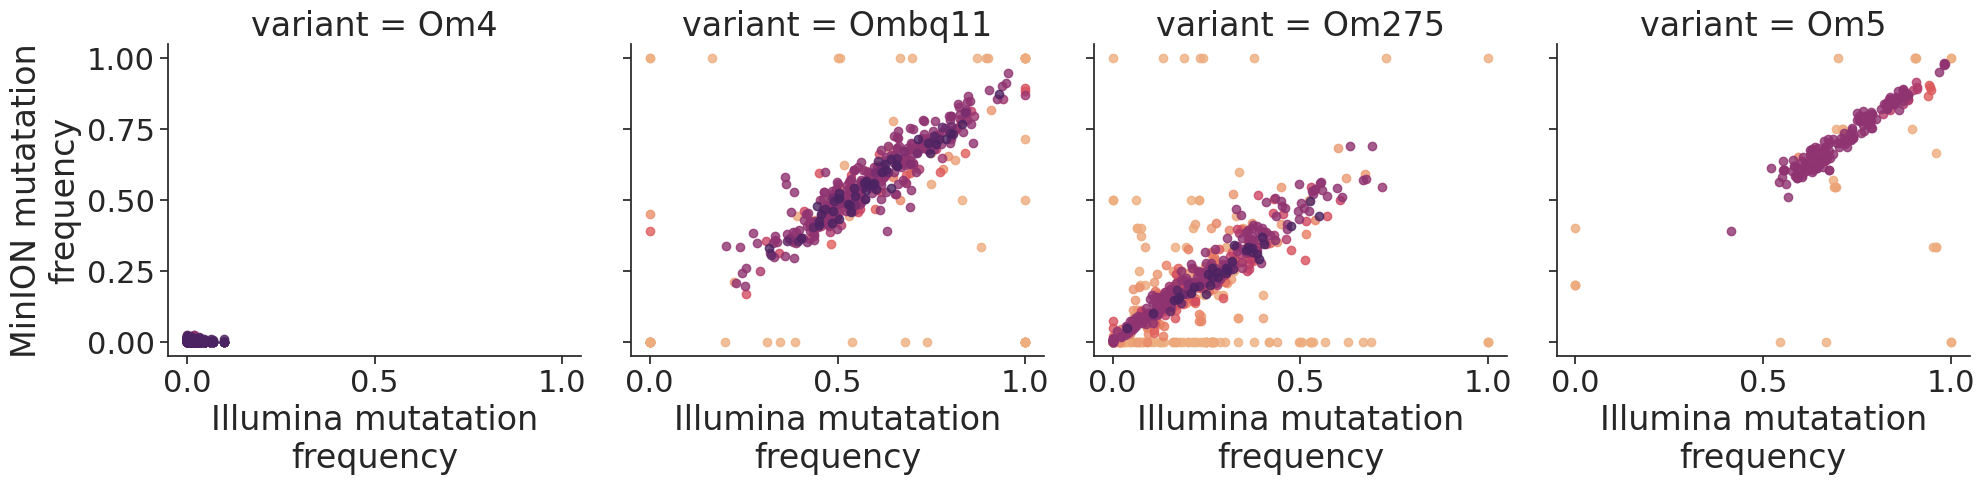

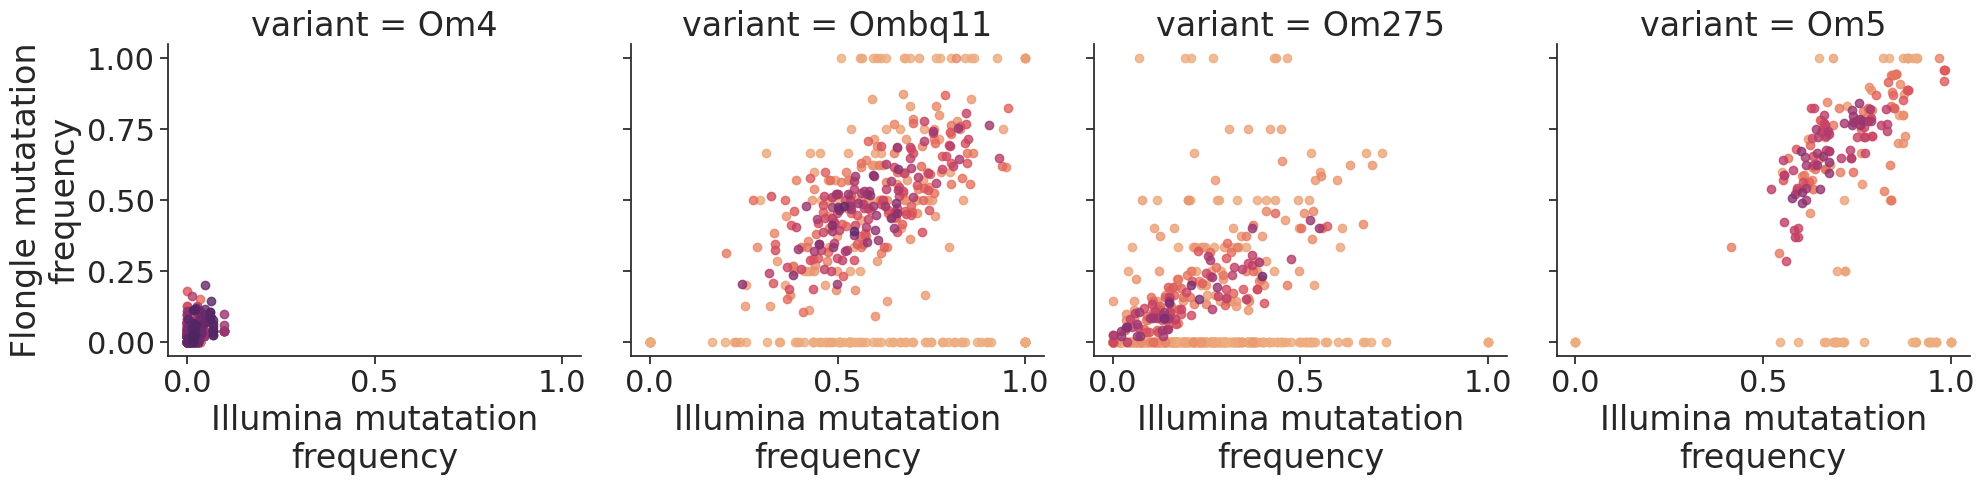

In [95]:
for i in range(1,len(plot_dfs)):
    g = sns.lmplot(data = df_filtered[df_filtered['variant'].isin(
        ['Om4', 'Om5','Ombq11','Om275'])], 
                   x = 'frac'+'_'+label_list[0],
                   y = 'frac'+'_'+label_list[i],
                   hue = 'covLog'+'_'+label_list[i],
#                    hue = 'covLog'+'_'+'Illumina',
                   col = "variant",
                   palette = "flare",
                   fit_reg = False,
                  legend = False)
    l = re.sub(r'[^A-Za-z|4]', '', label_list[i])
    g.set_axis_labels(y_var= l + ' mutatation'+'\n'+'frequency')
    g.set_axis_labels(label_list[0] + ' mutatation'+'\n'+'frequency')

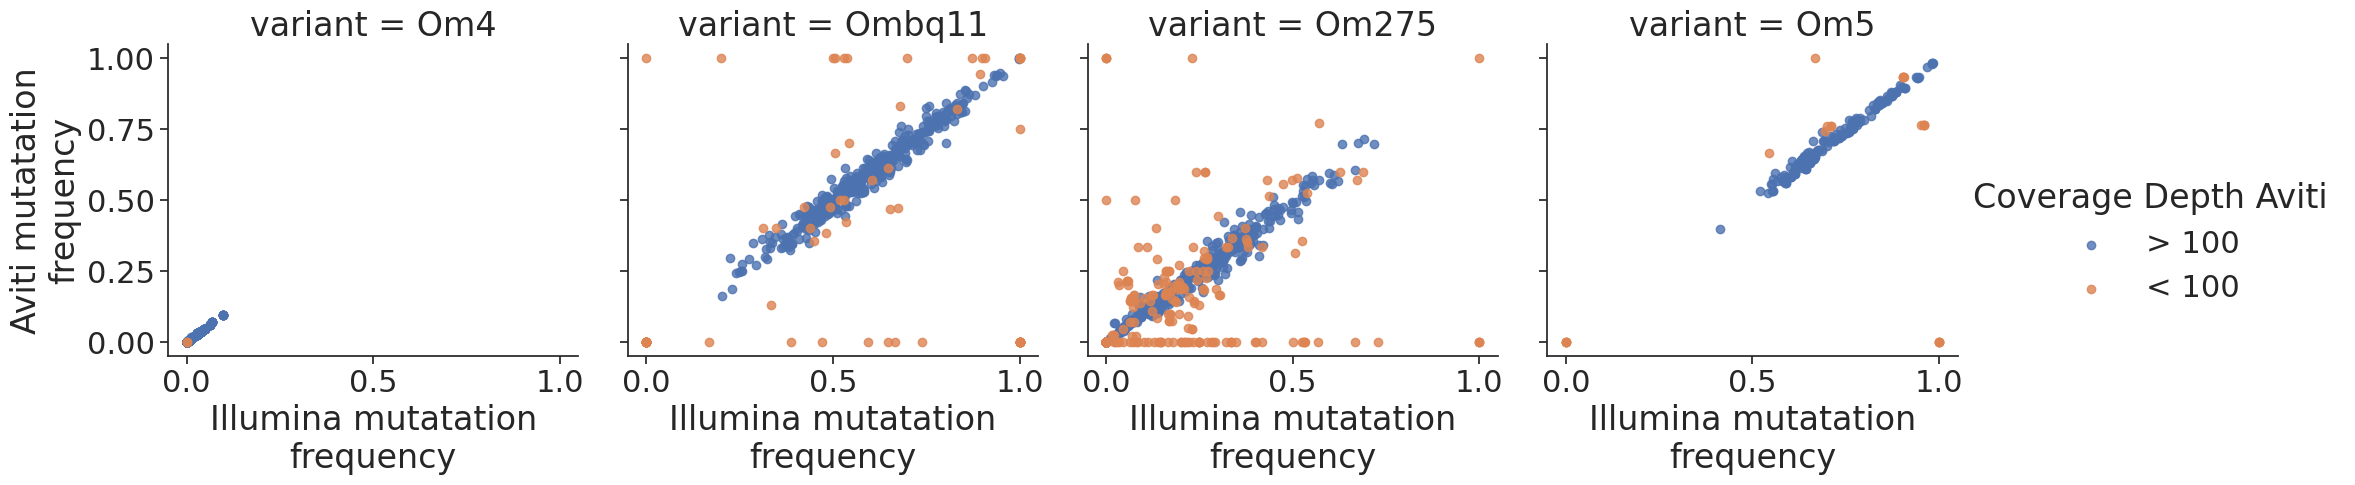

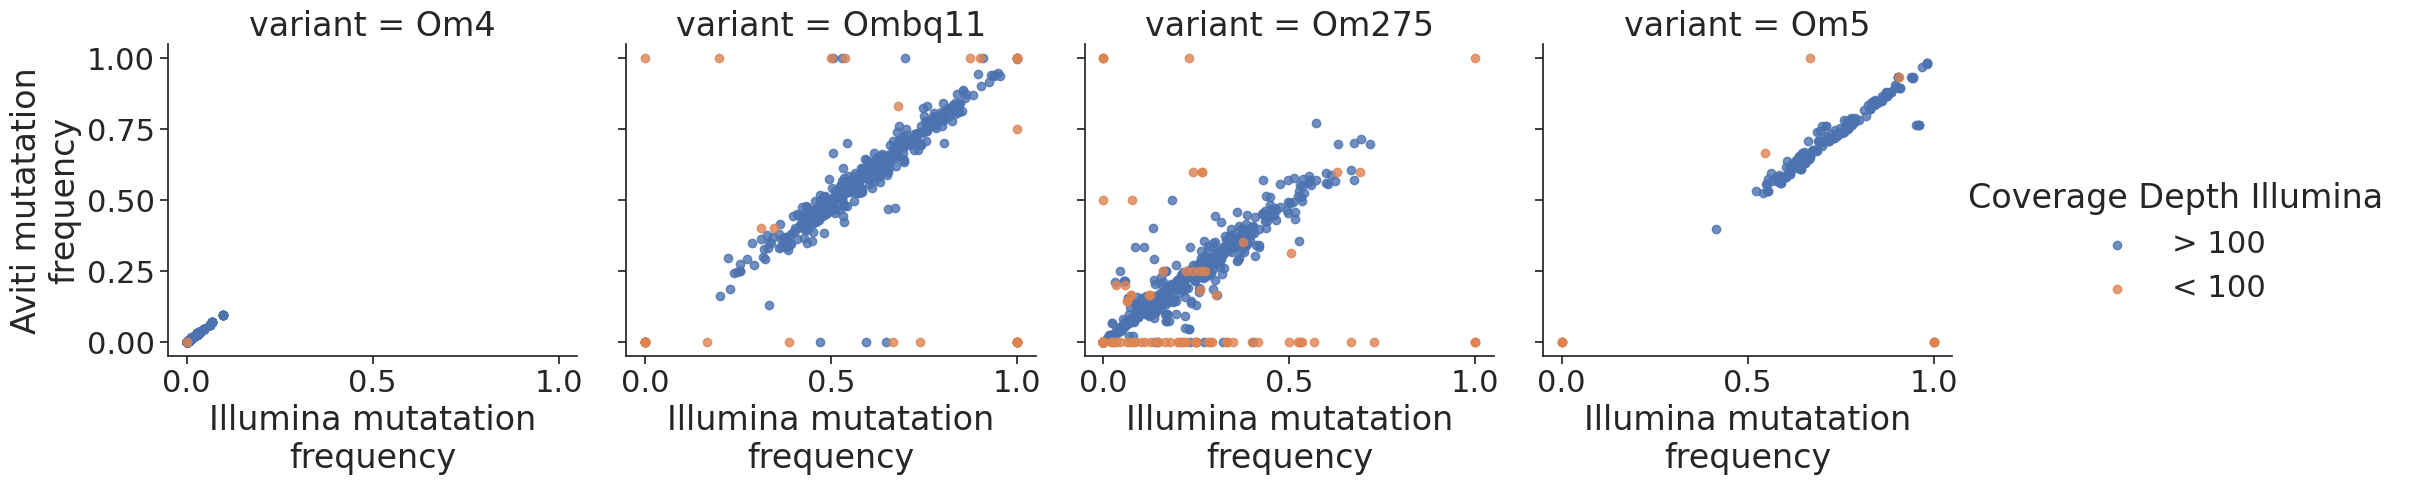

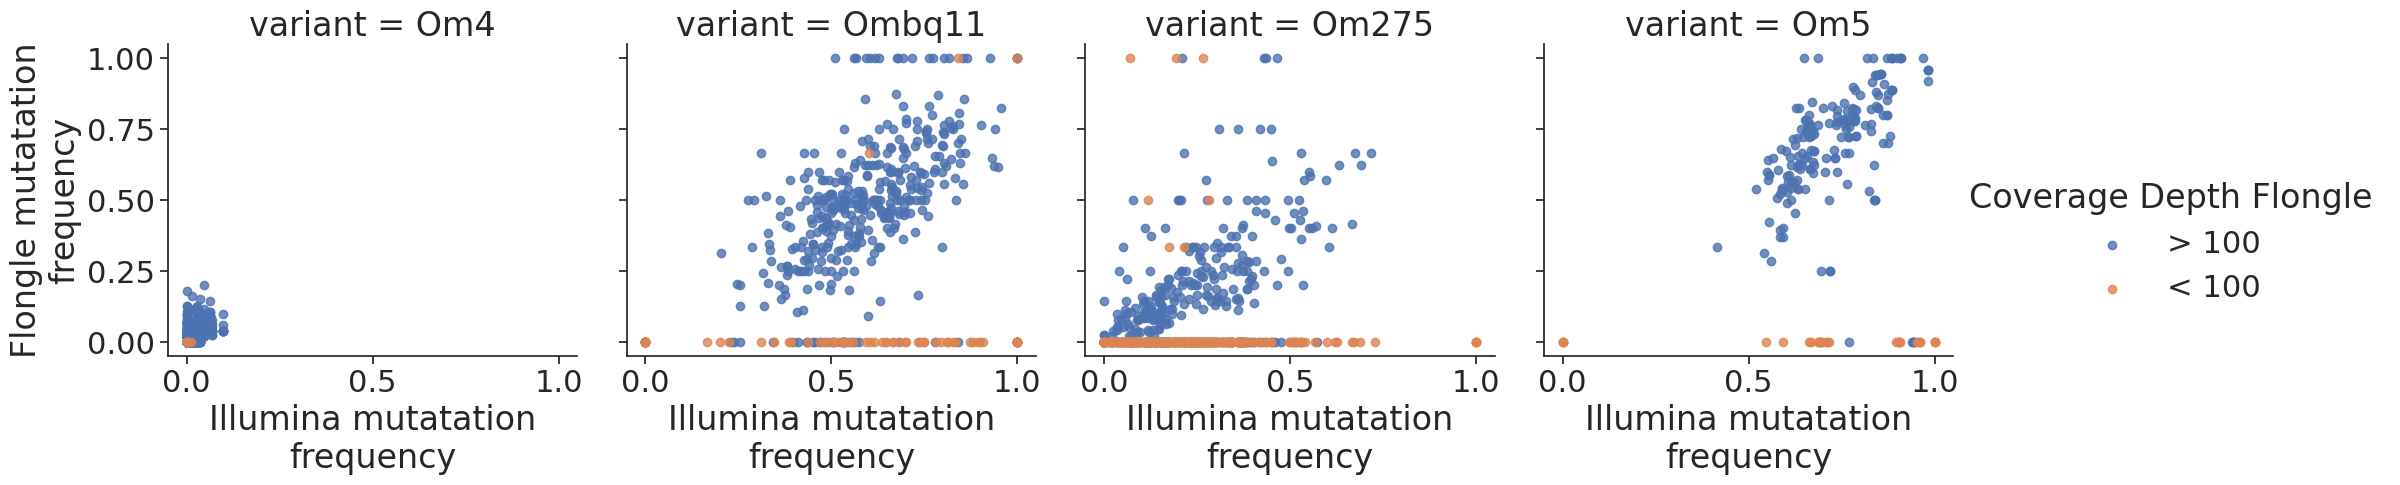

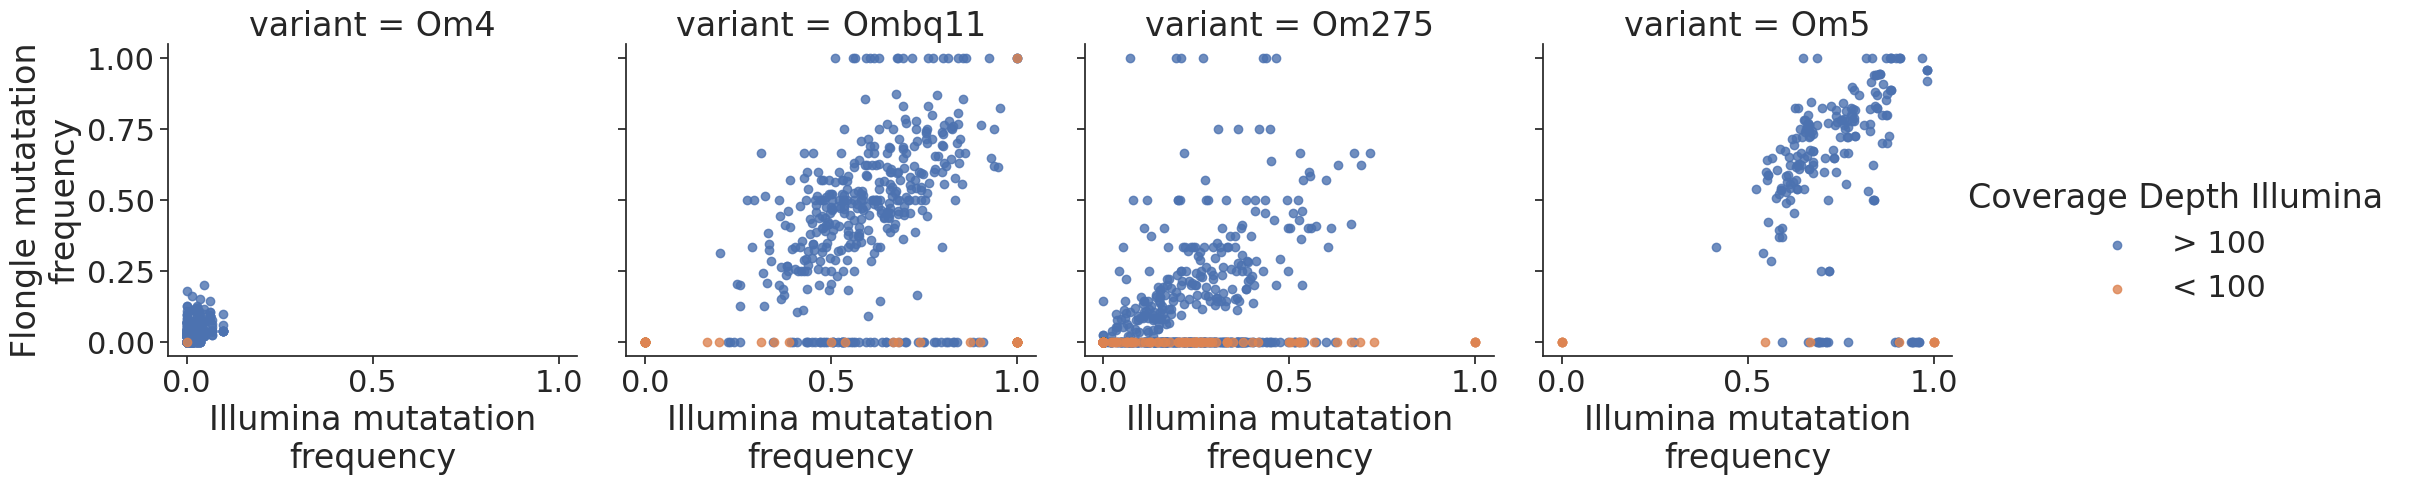

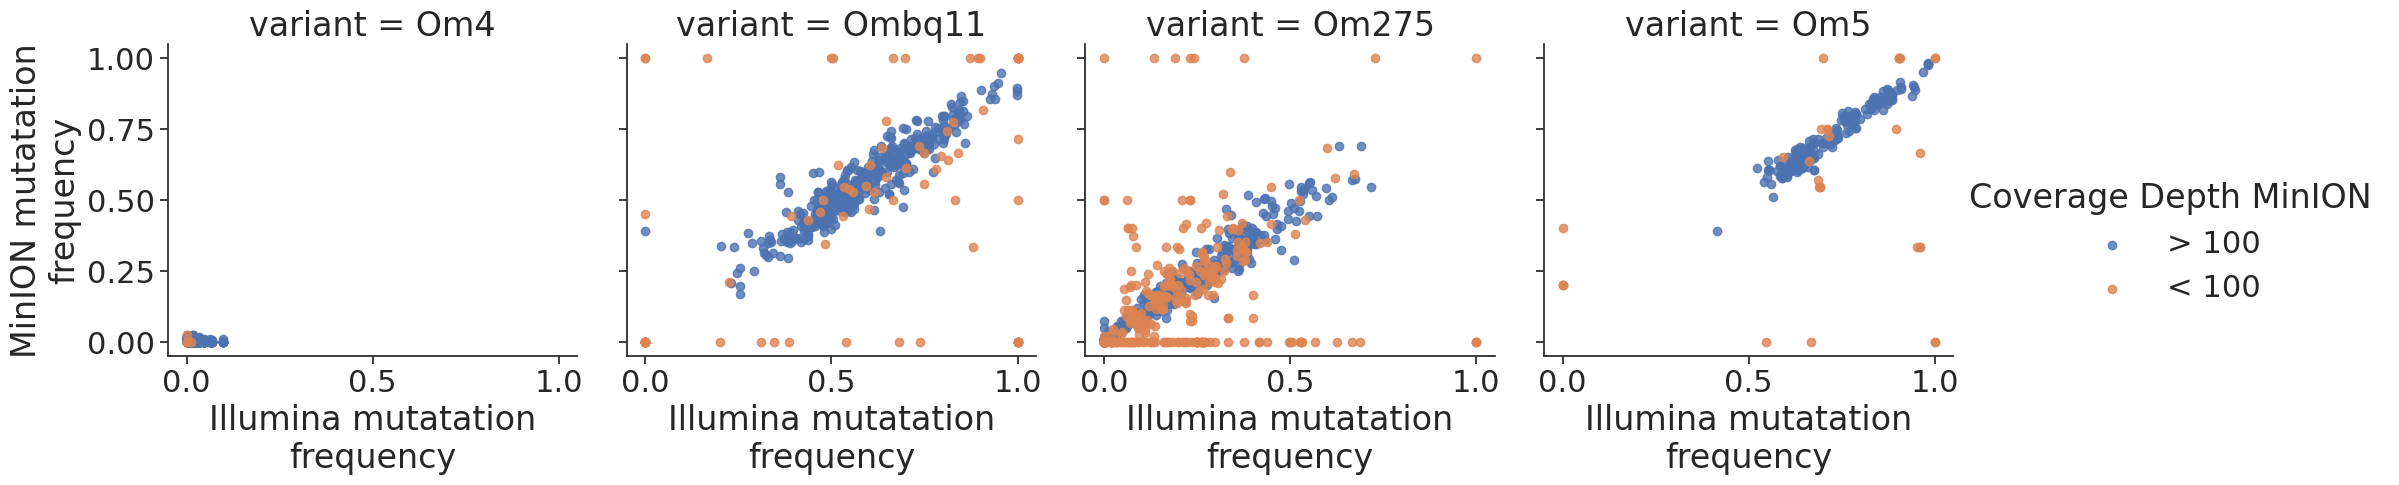

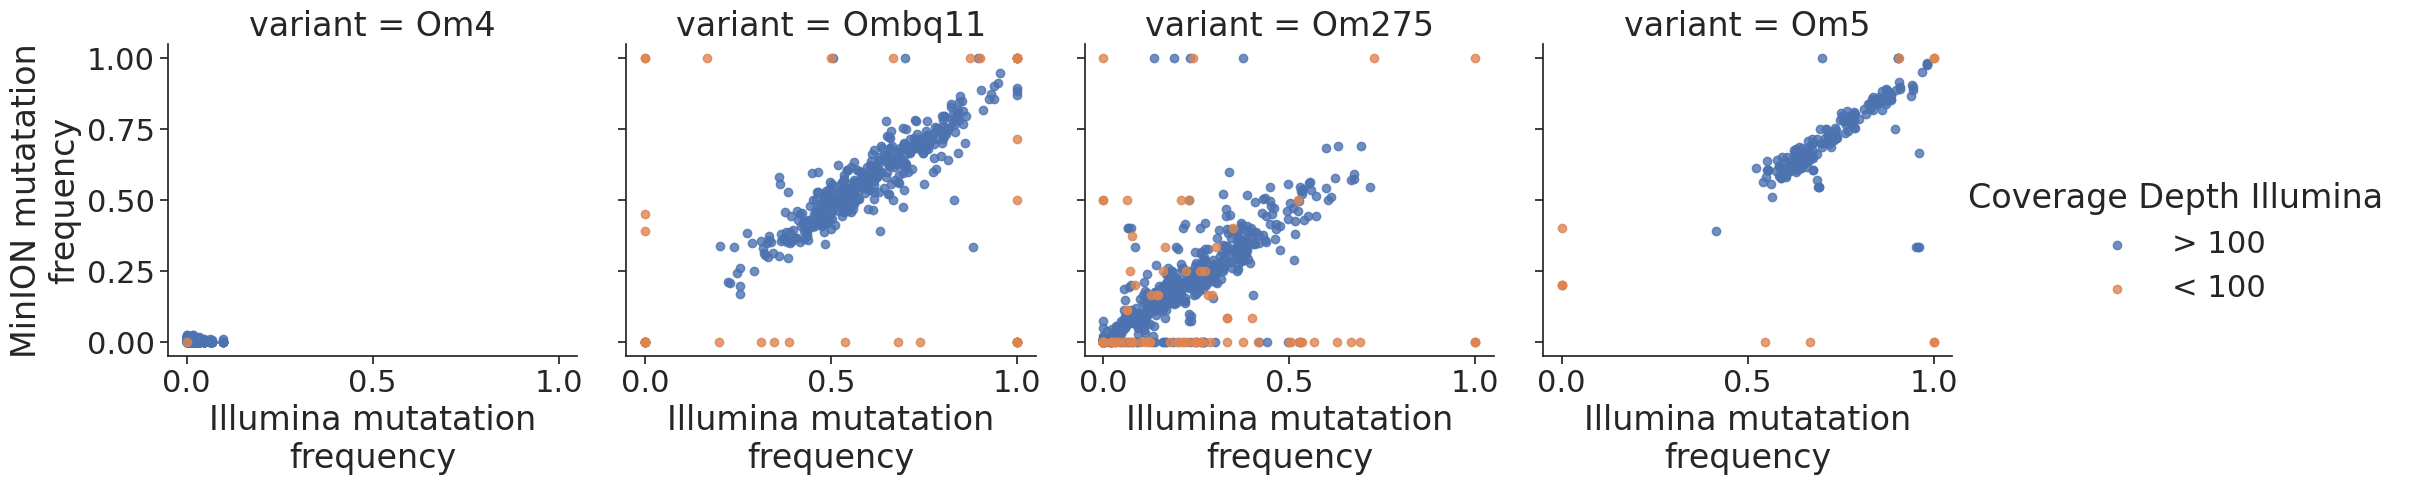

In [96]:
df = df_filtered[df_filtered['variant'].isin(['Om4', 'Om5','Ombq11','Om275'])]
df = df_filtered

df['Coverage Depth Illumina'] = np.where(df['cov_Illumina'] < 100, '< 100', '> 100')
df['Coverage Depth Aviti'] = np.where(df['cov_30556_Aviti'] < 100, '< 100', '> 100')
df['Coverage Depth MinION'] = np.where(df['cov_31108_MinION'] < 100, '< 100', '> 100')
df['Coverage Depth Flongle'] = np.where(df['cov_31108_MinION'] < 100, '< 100', '> 100')


g = sns.lmplot(data = df[df['variant'].isin(
    ['Om4', 'Om5','Ombq11','Om275'])], 
               x = 'frac'+'_'+label_list[0],
               y = 'frac'+'_'+'30556_Aviti',
               hue = 'Coverage Depth Aviti',
               col = "variant",
               palette ='deep',
               fit_reg = False,
              legend = True)
g.set_axis_labels(y_var= 'Aviti' + ' mutatation'+'\n'+'frequency')
g.set_axis_labels('Illumina' + ' mutatation'+'\n'+'frequency')

g = sns.lmplot(data = df[df['variant'].isin(
    ['Om4', 'Om5','Ombq11','Om275'])], 
               x = 'frac'+'_'+label_list[0],
               y = 'frac'+'_'+'30556_Aviti',
               hue = 'Coverage Depth Illumina',
               col = "variant",
               palette ='deep',
               fit_reg = False,
              legend = True)
g.set_axis_labels(y_var= 'Aviti' + ' mutatation'+'\n'+'frequency')
g.set_axis_labels('Illumina' + ' mutatation'+'\n'+'frequency')


g = sns.lmplot(data = df[df['variant'].isin(
    ['Om4', 'Om5','Ombq11','Om275'])], 
               x = 'frac'+'_'+label_list[0],
               y = 'frac'+'_'+'31108_Flongle',
               hue = 'Coverage Depth Flongle',
               col = "variant",
               palette ='deep',
               fit_reg = False,
              legend = True)
g.set_axis_labels(y_var= 'Flongle' + ' mutatation'+'\n'+'frequency')
g.set_axis_labels('Illumina' + ' mutatation'+'\n'+'frequency')

g = sns.lmplot(data = df[df['variant'].isin(
    ['Om4', 'Om5','Ombq11','Om275'])], 
               x = 'frac'+'_'+label_list[0],
               y = 'frac'+'_'+'31108_Flongle',
               hue = 'Coverage Depth Illumina',
               col = "variant",
               palette ='deep',
               fit_reg = False,
              legend = True)
g.set_axis_labels(y_var= 'Flongle' + ' mutatation'+'\n'+'frequency')
g.set_axis_labels('Illumina' + ' mutatation'+'\n'+'frequency')


g = sns.lmplot(data = df[df['variant'].isin(
    ['Om4', 'Om5','Ombq11','Om275'])], 
               x = 'frac'+'_'+label_list[0],
               y = 'frac'+'_'+'31108_MinION',
               hue = 'Coverage Depth MinION',
               col = "variant",
               palette ='deep',
               fit_reg = False,
              legend = True)
g.set_axis_labels(y_var= 'MinION' + ' mutatation'+'\n'+'frequency')
g.set_axis_labels('Illumina' + ' mutatation'+'\n'+'frequency')

g = sns.lmplot(data = df[df['variant'].isin(
    ['Om4', 'Om5','Ombq11','Om275'])], 
               x = 'frac'+'_'+label_list[0],
               y = 'frac'+'_'+'31108_MinION',
               hue = 'Coverage Depth Illumina',
               col = "variant",
               palette ='deep',
               fit_reg = False,
              legend = True)
g.set_axis_labels(y_var= 'MinION' + ' mutatation'+'\n'+'frequency')
g.set_axis_labels('Illumina' + ' mutatation'+'\n'+'frequency')



# Spike-in Experiment

In [97]:
sns.set_context("notebook", font_scale=1.25)
colors = sns.color_palette("tab20")
variants = list(df_deconvs_long_bind.variable.unique())
colors_sub = colors[0:len(variants)]
palette = {variants[i]: colors_sub[i] for i in range(len(variants))}
gT_omicron = groundTruth[['location','Omicron_frac','Omicron_frac_calibrated']]
gT_omicron['variable'] = 'groundTruth_Omicron'
gT_omicron = gT_omicron.rename(columns={'Omicron_frac_calibrated':'value'})

/scratch/tmp.50022044.anjohn/ipykernel_148987/440824689.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gT_omicron['variable'] = 'groundTruth_Omicron'


In [110]:
df_deconvs_long_bind['batch'] = df_deconvs_long_bind['sample'].apply(lambda x: batch_dic[x])
df_deconvs_long_bind.batch = df_deconvs_long_bind.batch.str.capitalize()
df_deconvs_long_bind['batch'] = df_deconvs_long_bind['batch'].apply(lambda x: re.sub(r'(\d)', r' \1', x))

df_deconvs_long_bind.sample_class = df_deconvs_long_bind.sample_class.str.capitalize()
df_deconvs_long_bind["sample_class"] = df_deconvs_long_bind.sample_class.str.replace('Minion', 'MinION')
df_deconvs_long_bind["sample_class"] = df_deconvs_long_bind["sample_class"].str.replace('raw', '')


/scratch/tmp.50022044.anjohn/ipykernel_148987/1225562189.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 22)
/scratch/tmp.50022044.anjohn/ipykernel_148987/1225562189.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 22)
/scratch/tmp.50022044.anjohn/ipykernel_148987/1225562189.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 22)
/scratch/tmp.50022044.anjohn/ipykernel_148987/1225562189.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 22)
/scratch/tmp.50022044.anjohn/ipykernel_148987/1225562189.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 22)
/scratch/tmp.50022044.anjohn/ipykernel_148987/1225562189.py:

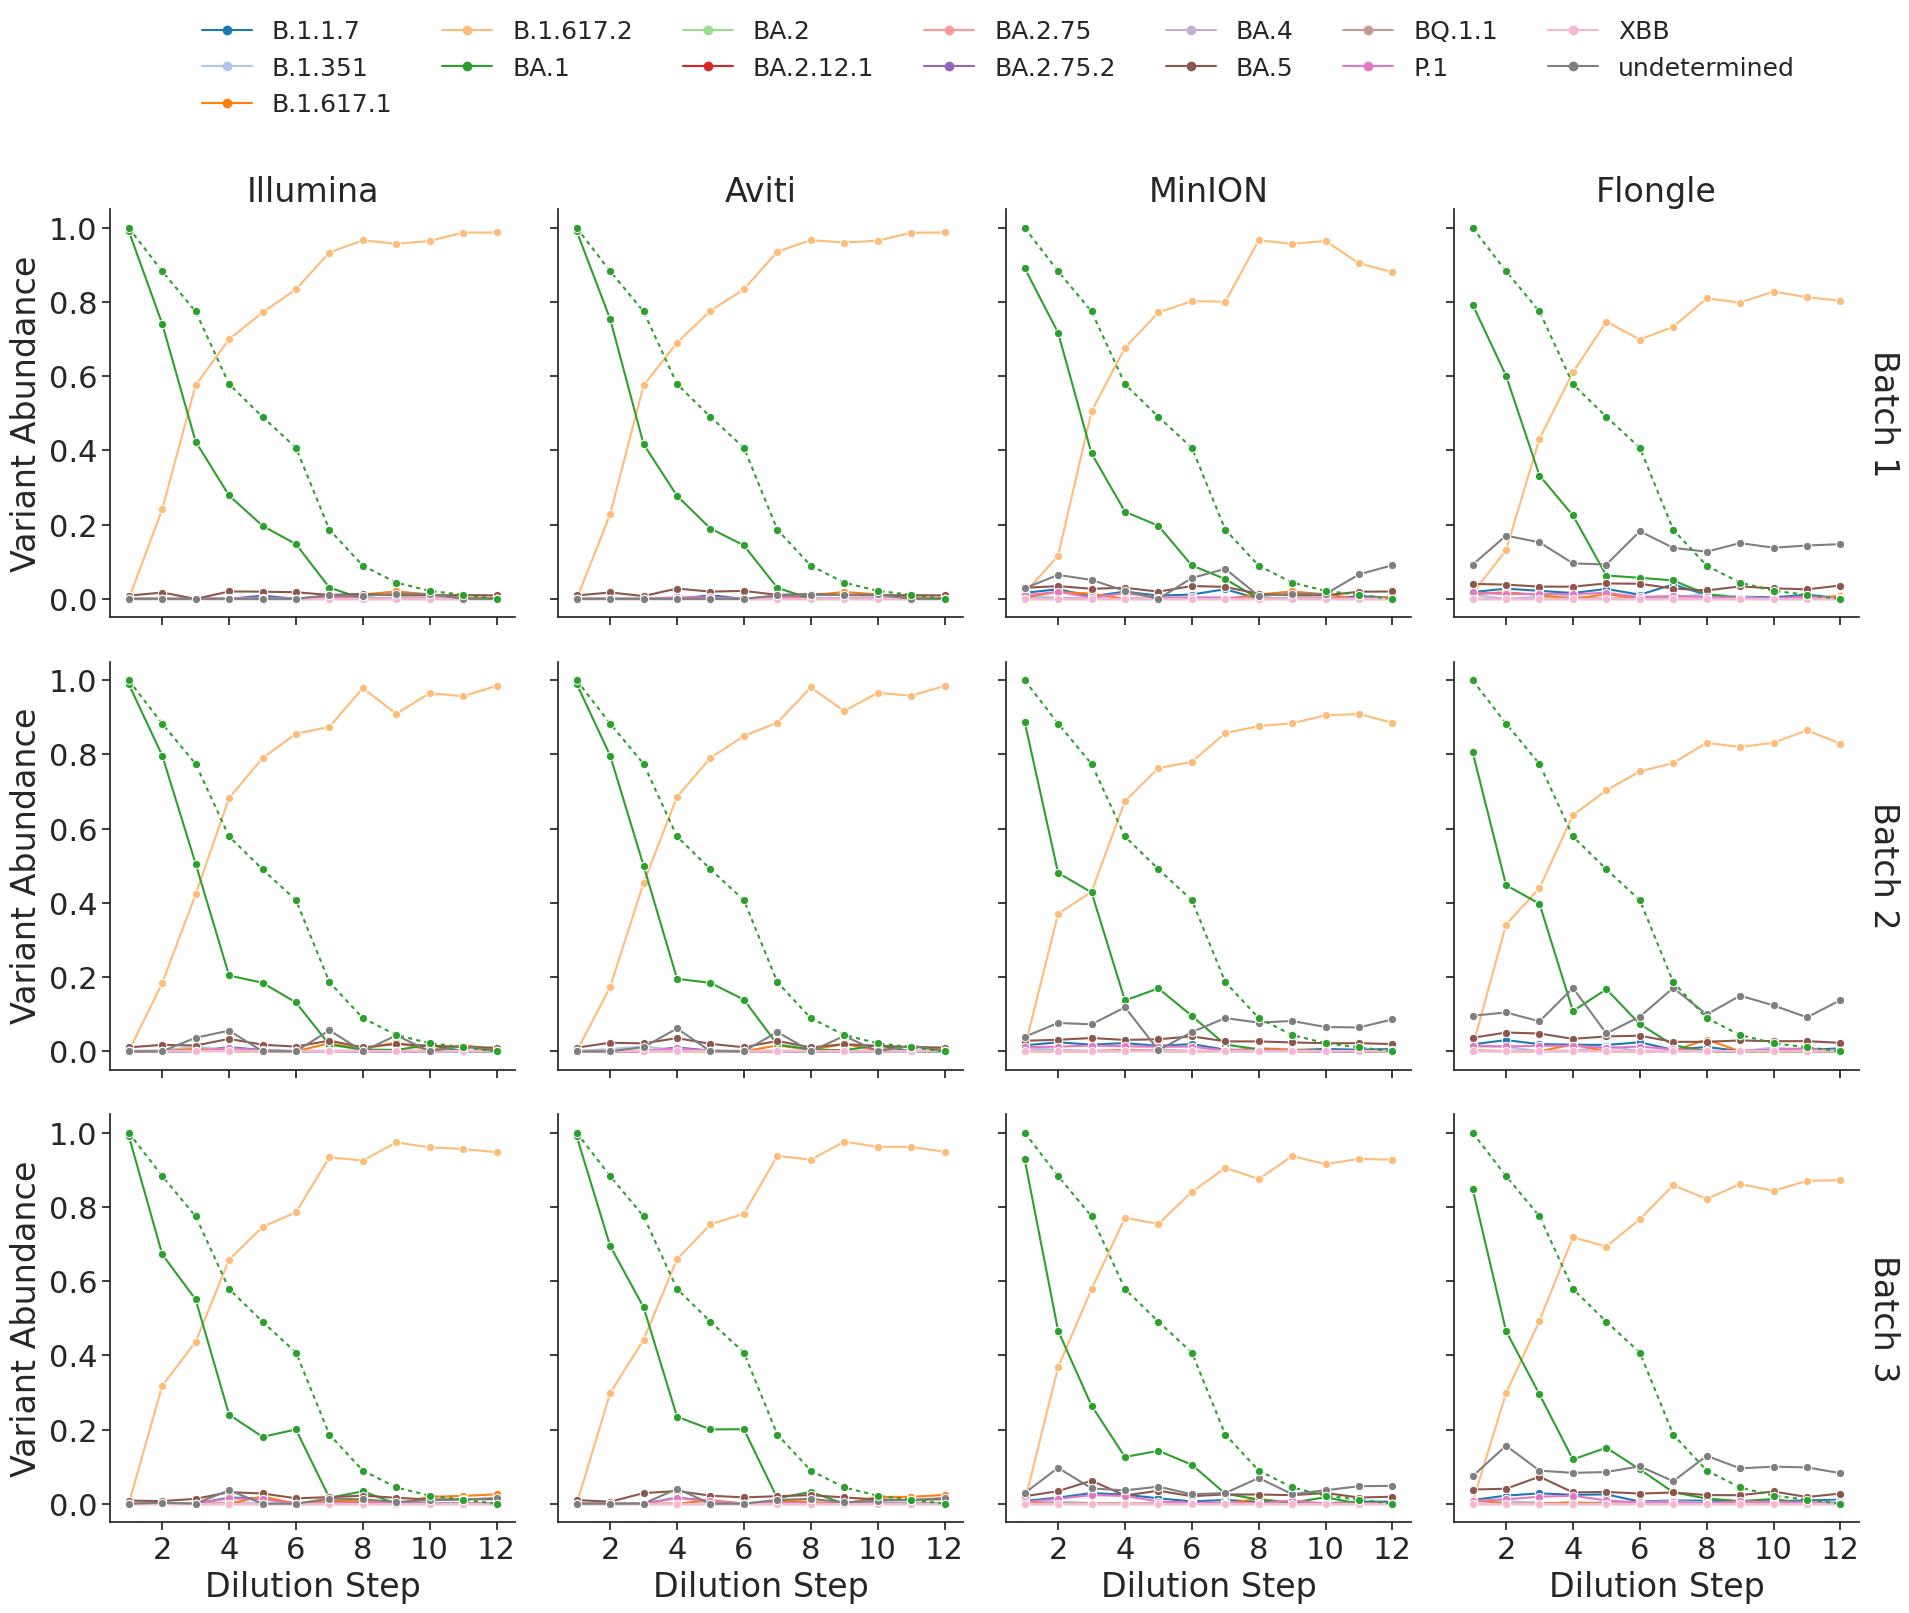

In [147]:
sns.set(font_scale=2,style="ticks")


lable_order = ['Illumina', 'Aviti', 'MinION', 'Flongle']

# I think bands represent the range of values, not sure if bootstrap or not
lineplot = sns.relplot(data=df_deconvs_long_bind, x='location', y="value", hue='variable',
                       kind='line', col='sample_class',row = 'batch',palette='tab20', 
                       col_order=lable_order,facet_kws={"margin_titles": True},
                       style = 'variable',dashes=False,
                       markers=["o", "o","o", "o","o",
                               "o", "o","o", "o","o",
                               "o", "o","o", "o","o"])

(lineplot.set_axis_labels("Dilution Step", "Variant Abundance",size = 24)
 .set_titles(col_template="{col_name}", row_template="{row_name}"))

matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.title_fontsize'] = 20
i = 0

for ax in lineplot.axes.flat:
    
#     sample_class = ax.get_title().split(' = ')[1]
    
    ax = sns.lineplot(data=gT_omicron, 
                 x='location', 
                 y="value", 
                 hue='variable',
                 ax=ax, 
                 legend=False, 
                 palette=[palette["BA.1"]],
                 style = 'variable',
#                  markers = True,
                 markers={"groundTruth_Omicron": 'o'},
                 dashes={"groundTruth_Omicron": (2, 2)}
                )
    
#     ax.lines[0].set_linestyle('--')
    
#     ax.set_title(lable_order[i],size =24)

    ax.set_xticks(range(2,13,2))

    ax.set_xticklabels(ax.get_xticks(), size = 22)
    ax.set_yticklabels(ax.get_yticks(), size = 22)
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
    
    
    i = i+1

sns.move_legend(
    lineplot, "lower center",
    bbox_to_anchor=(.45, 1), ncol=7,title=None, frameon=False,
)

lineplot.savefig(out_dir+"/SpikeIN_Abundance_byBatch.png",bbox_inches='tight',dpi=600) 

AttributeError: 'Axes' object has no attribute 'set_titles'

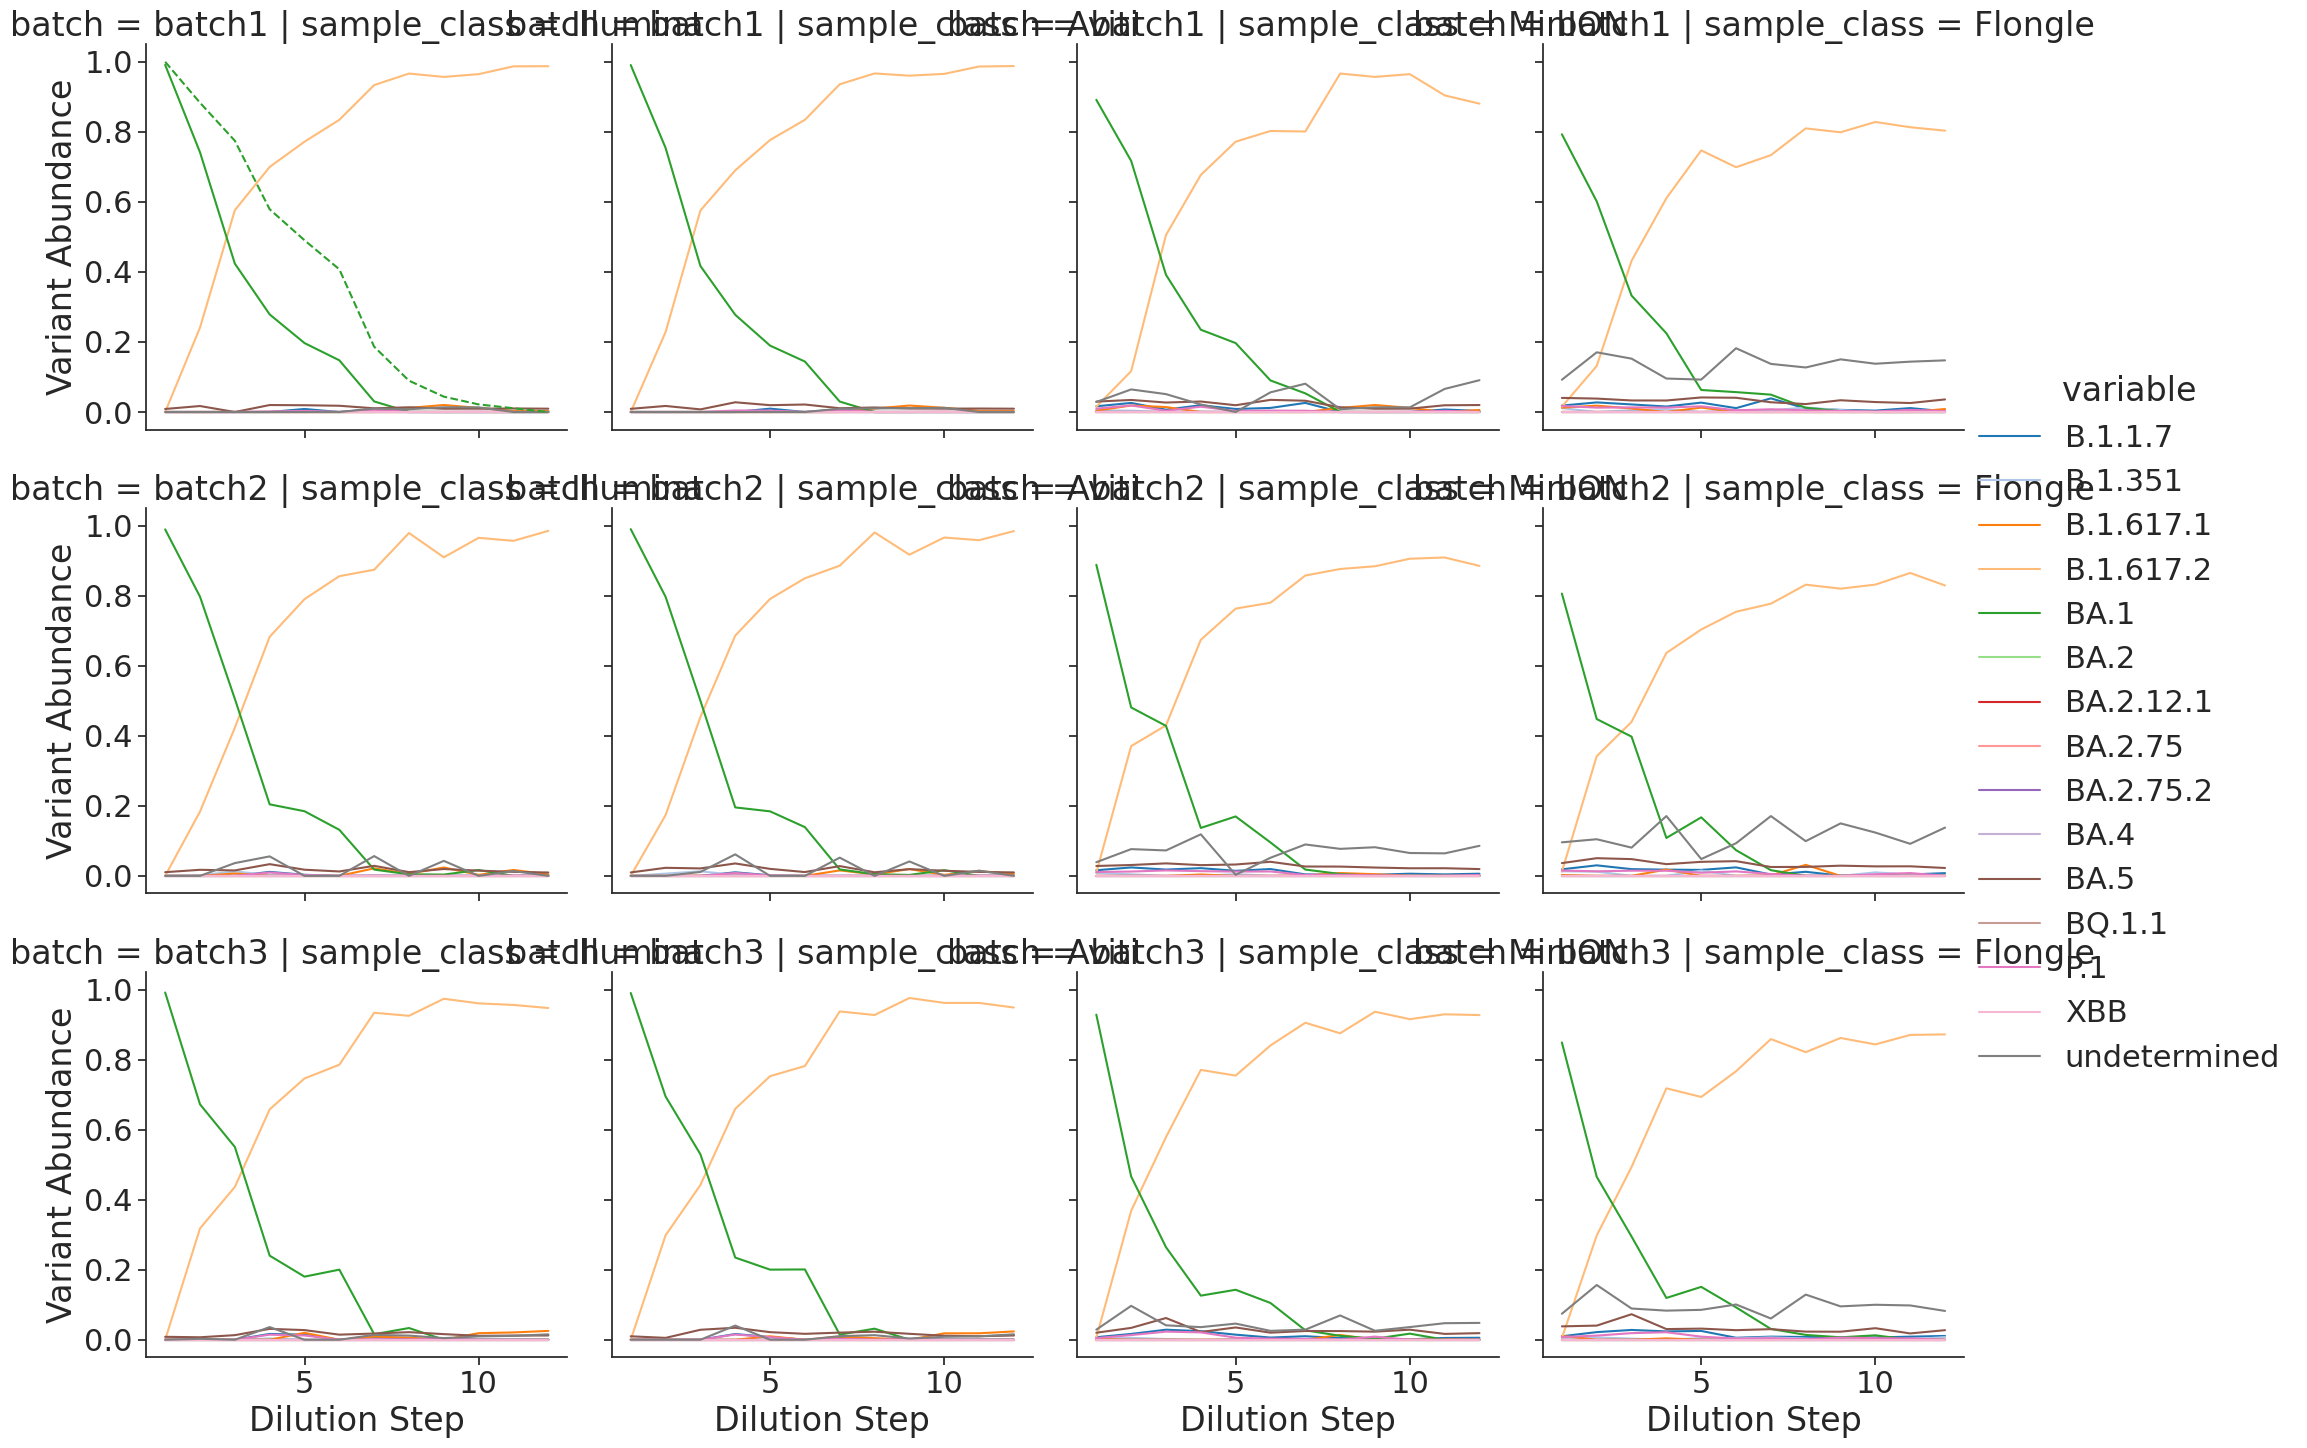

In [60]:
sns.set(font_scale=2,style="ticks")

df_deconvs_long_bind.sample_class = df_deconvs_long_bind.sample_class.str.capitalize()
df_deconvs_long_bind["sample_class"] = df_deconvs_long_bind.sample_class.str.replace('Minion', 'MinION')
df_deconvs_long_bind["sample_class"] = df_deconvs_long_bind["sample_class"].str.replace('raw', '')

lable_order = ['Illumina', 'Aviti', 'MinION', 'Flongle']

# I think bands represent the range of values, not sure if bootstrap or not
lineplot = sns.relplot(data=df_deconvs_long_bind, x='location', y="value", hue='variable',
                       kind='line', col='sample_class',row = 'batch',palette='tab20', col_order=lable_order)

# Adjust the plot labels and titles
lineplot.set_axis_labels("Dilution Step", "Variant Abundance",size = 24)

matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.title_fontsize'] = 20
i = 0

for ax in lineplot.axes.flat:
    
    sample_class = ax.get_title().split(' = ')[1]
    
#     sns.lineplot(data=gT_omicron, x='location', y="value", hue='variable',
#                  ax=ax, legend=False, linestyle = '--', palette=[palette["BA.1"]])
    
# #     ax.set_title(lable_order[i],size =24)
#     ax.set_title(col_template="{col_name}", row_template="{row_name}")

#     ax.set_xticks(range(2,13,2))

#     ax.set_xticklabels(ax.get_xticks(), size = 22)
#     ax.set_yticklabels(ax.get_yticks(), size = 22)
    
    
#     ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
#     ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
    
    
    g = sns.lineplot(data=gT_omicron, x='location', y="value", hue='variable',
                 ax=ax, legend=False, linestyle = '--', palette=[palette["BA.1"]])
    
#     ax.set_title(lable_order[i],size =24)
    g.set_titles(col_template="{col_name}", row_template="{row_name}")

    g.set_xticks(range(2,13,2))

    g.set_xticklabels(ax.get_xticks(), size = 22)
    g.set_yticklabels(ax.get_yticks(), size = 22)
    
    
    g.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
    
    
    
    i = i+1


# lineplot._legend.set_title('Variant')
sns.move_legend(
    lineplot, "lower center",
    bbox_to_anchor=(.45, 1), ncol=7,title=None, frameon=False,
)

# lineplot.savefig(out_dir+"/SpikeIN_Abundance.png",bbox_inches='tight',dpi=600) 

##### Prepare df for regression analysis

In [52]:
df_reg = df_deconvs_long_bind.loc[(df_deconvs_long_bind.variable == 'BA.1') |
                        (df_deconvs_long_bind.variable == 'B.1.617.2')].merge(
    groundTruth[['location','Omicron_frac','Omicron_frac_calibrated']])
df_reg['batch'] = df_reg['sample'].apply(lambda x: batch_dic[x])

# df_reg.to_csv(out_dir + "/df_regression.csv")

### Estimating per position error rate 

From non-diluted spike-in samples (BA.1 realtive abundance expected to be 1.0) we try to deduce error rate, because here there does not seem such a big deviation in abundance estimates. 
- use only BA.1 signature mutations


In [48]:
df_error = pd.concat([make_error_df(df_tally_merge_batch1),
                    make_error_df(df_tally_merge_batch2),
                    make_error_df(df_tally_merge_batch3)]).reset_index(drop=True)
df_plot = df_error 

df_plot['Tech'] = df_plot['Tech'].apply(lambda x: x[0].upper() + x[1:] if x else x)
df_plot['sample'] = df_plot['sample'].str.removeprefix("frac_")
df = df_tally_mergeLong_spike[df_tally_mergeLong_spike['pos'].isin(df_plot.pos)]
df_plot = df_plot.merge(df, on = ['pos','sample'], how = 'left')
df_plot = df_plot[df_plot['cov'] > 0] #not covered positions do not contain info

In [71]:
df_plot.pos.unique()

array([ 2832,  5386,  6513,  6514,  6515,  8393, 11537, 13195, 15240,
       21762, 21846, 21987, 21988, 21989, 21990, 21991, 21995, 22194,
       22195, 22196, 22673, 22675, 23048, 23202, 24130, 24503, 26530])

In [76]:
len(BA1_sig_adapted)

13

#### Mean Sequencing error rate

In [49]:
df_plot[['Tech','Error rate']].groupby(['Tech']).mean('Error rate')

Error rate
Tech                
Aviti       0.002082
Flongle     0.184618
Illumina    0.003146
MinION      0.117163

#### Mean sequencing error rate 
This time only considering point muations.

In [74]:
#based on our voc yaml re-define signature mutations
BA1_sig_adapted = [2832,5386,8393, 11537, 13195, 15240, 21762, 21846,23048, 23202, 24130, 24503, 26530]

In [86]:
df_plot_alt.pos.unique()

array([ 2832,  5386,  8393, 11537, 13195, 15240, 21762, 21846, 23048,
       23202, 24130, 24503, 26530])

In [83]:
df_plot_alt = df_plot.loc[df_plot['pos'].isin(BA1_sig_adapted)]
df_plot_alt[['Tech','Error rate']].groupby(['Tech']).mean('Error rate')

Error rate
Tech                
Aviti       0.003169
Flongle     0.207638
Illumina    0.003789
MinION      0.100938

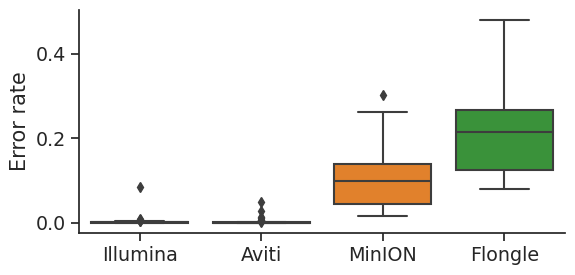

In [87]:
sns.set(font_scale=1.25,style="ticks")

g = sns.catplot(data=df_plot_alt,
            x="Tech",
            y="Error rate",
            kind="box",
            order = ['Illumina','Aviti','MinION','Flongle'],
            palette = paletteB,
            legend= False,
            height=3, 
            aspect=2)
g.set(xlabel = '')

plt.tight_layout()
plt.savefig(out_dir + "/SeqErrorRate_spikeIN_BoxPlot_alt.png",dpi=600)

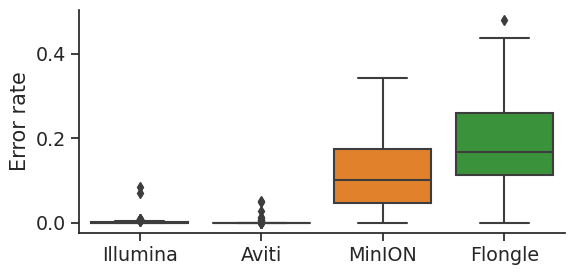

In [91]:
sns.set(font_scale=1.25,style="ticks")

g = sns.catplot(data=df_plot,
            x="Tech",
            y="Error rate",
            kind="box",
            order = ['Illumina','Aviti','MinION','Flongle'],
            palette = paletteB,
            legend= False,
            height=3, 
            aspect=2)
g.set(xlabel = '')

plt.tight_layout()
plt.savefig(out_dir + "/SeqErrorRate_spikeIN_BoxPlot.png",dpi=600)

/cluster/home/anjohn/.local/lib/python3.8/site-packages/seaborn/relational.py:858: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


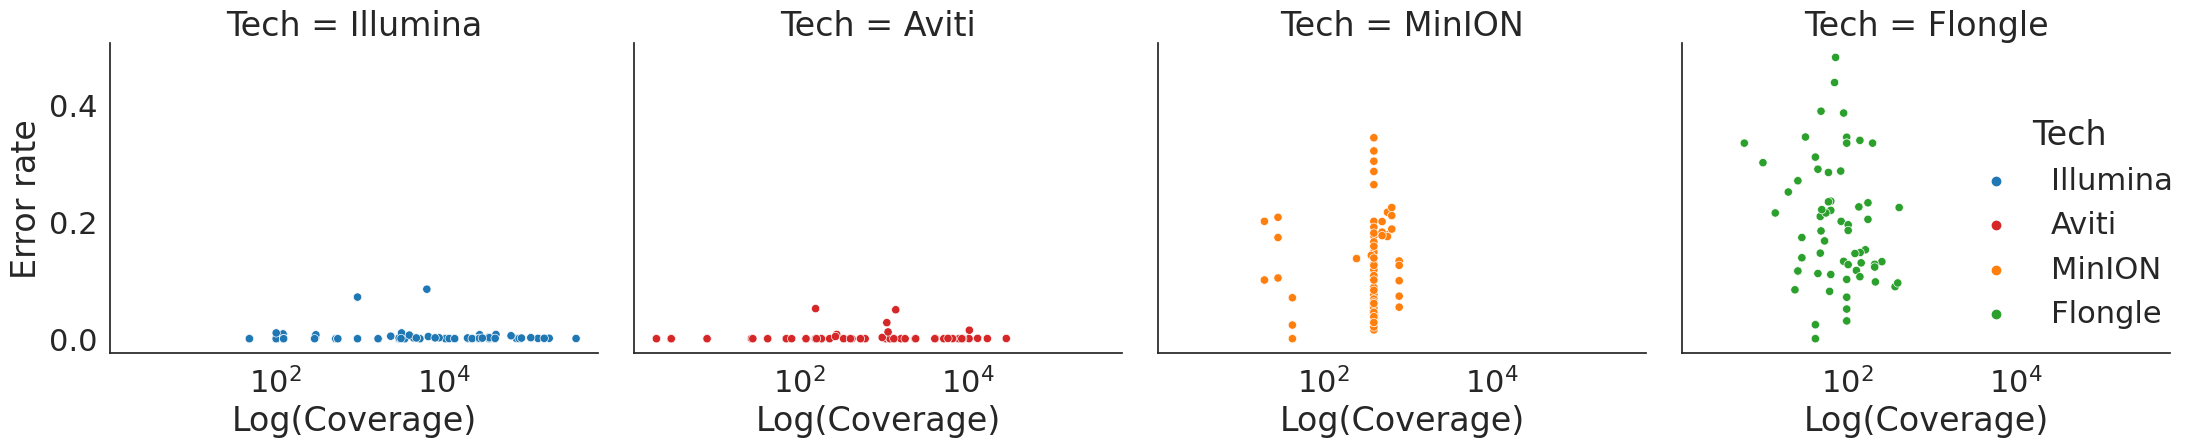

In [105]:
# fig, axes = plt.subplots(figsize=(15*0.75, 12*0.75))
sns.set(font_scale=2,style="white")
g = sns.relplot(df_plot, 
             x='cov',
            y = 'Error rate',
            hue = 'Tech',
           col = 'Tech',
           palette = paletteB,
           col_order = lable_order,
           hue_order = lable_order,
            ax = axes)

g.set(xscale="log",
      xlabel = 'Log(Coverage)')

plt.tight_layout()
plt.savefig(out_dir + "/SeqErrorRate_spikeIN_byCov.png",dpi=600)

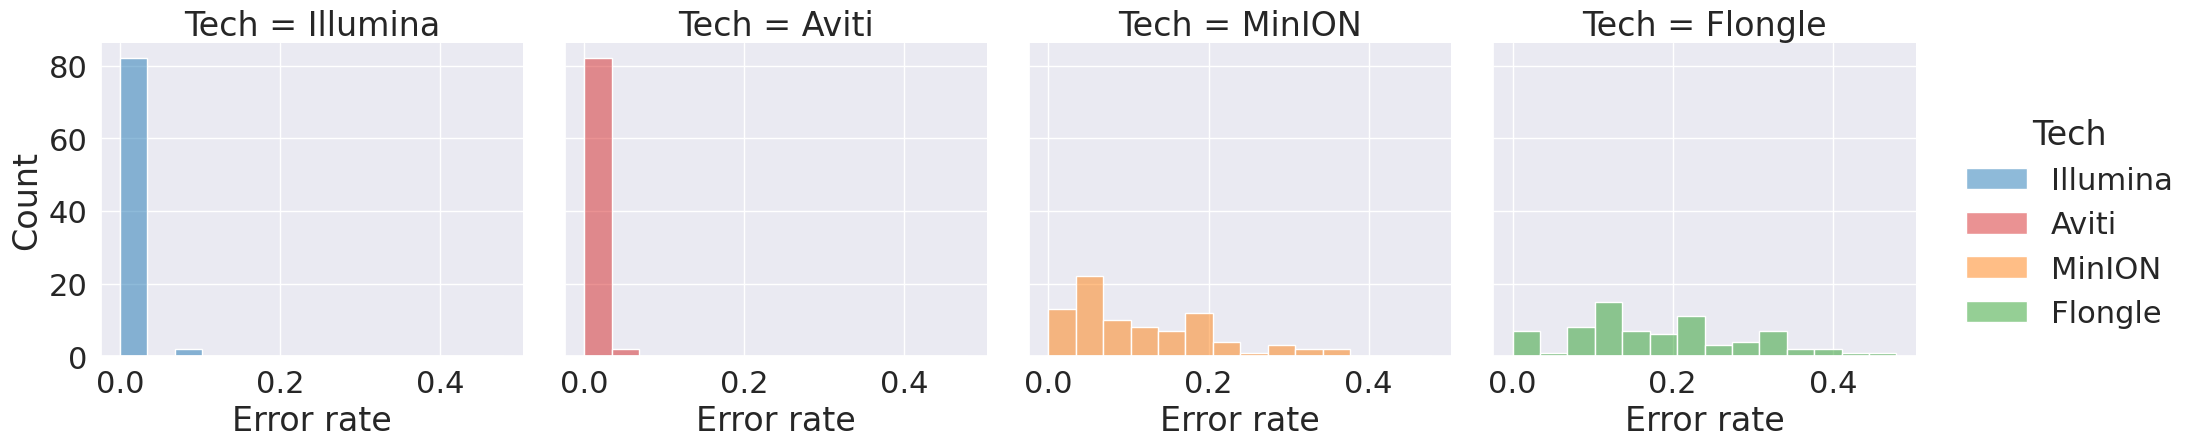

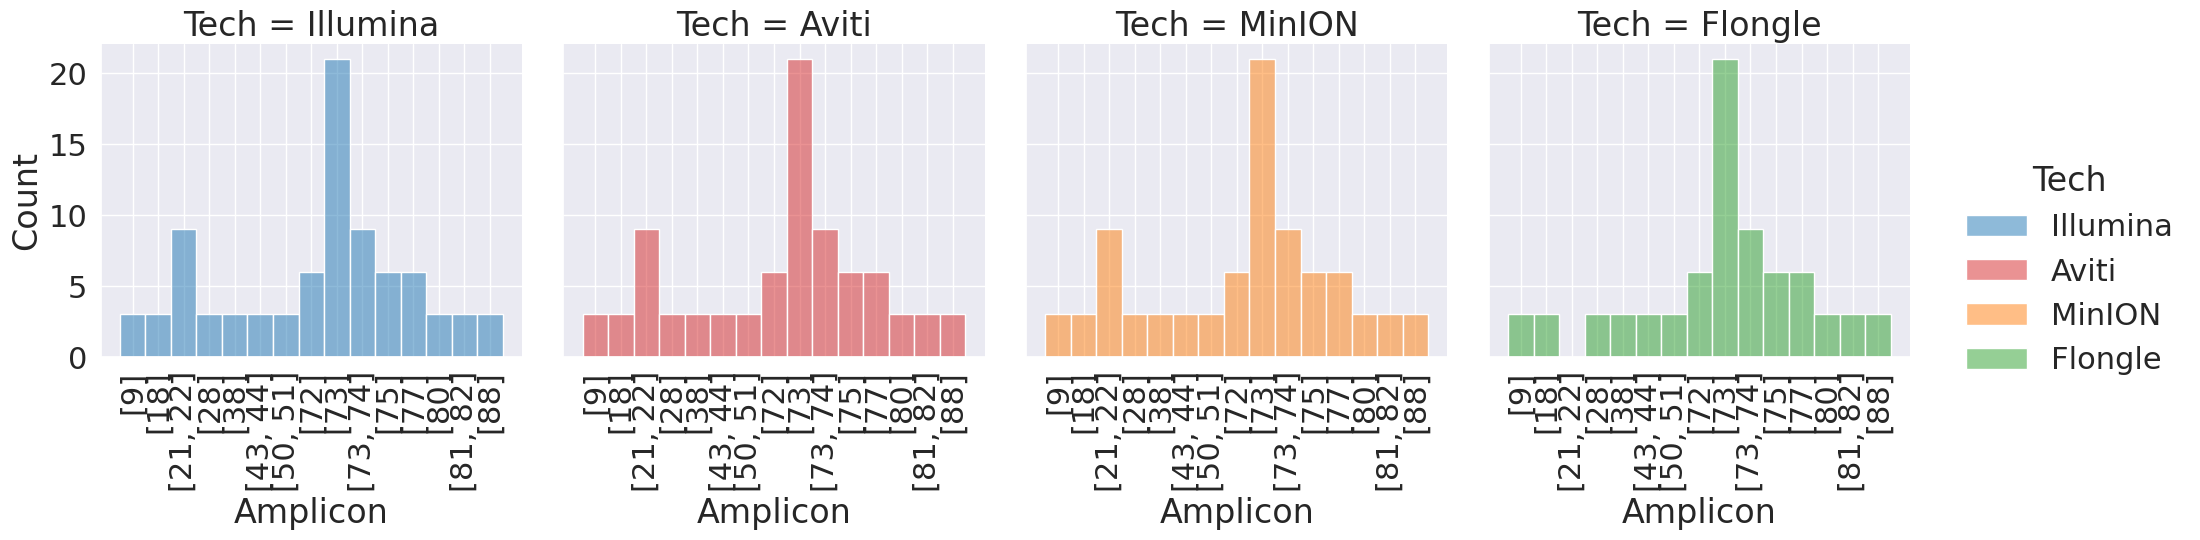

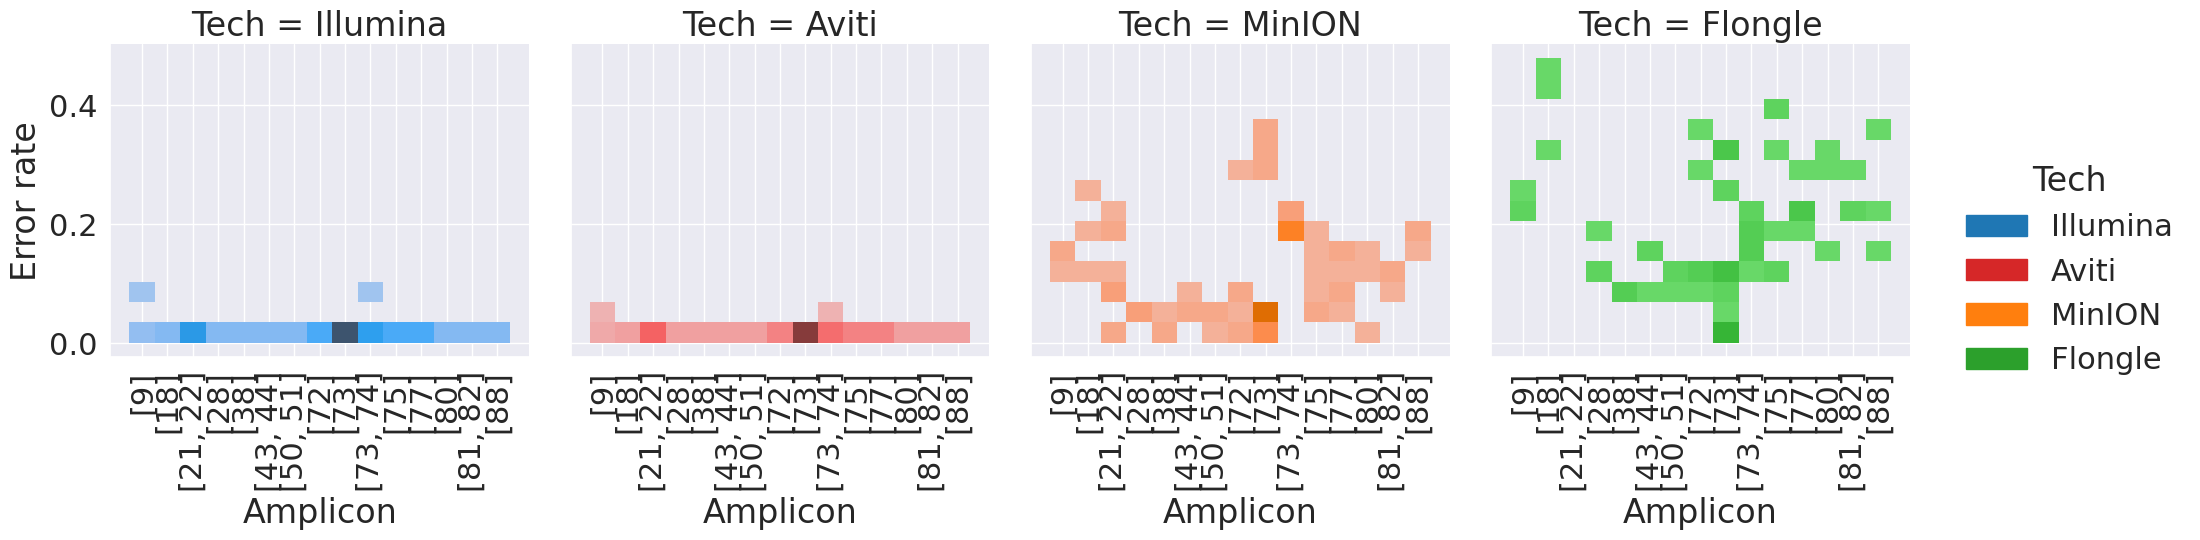

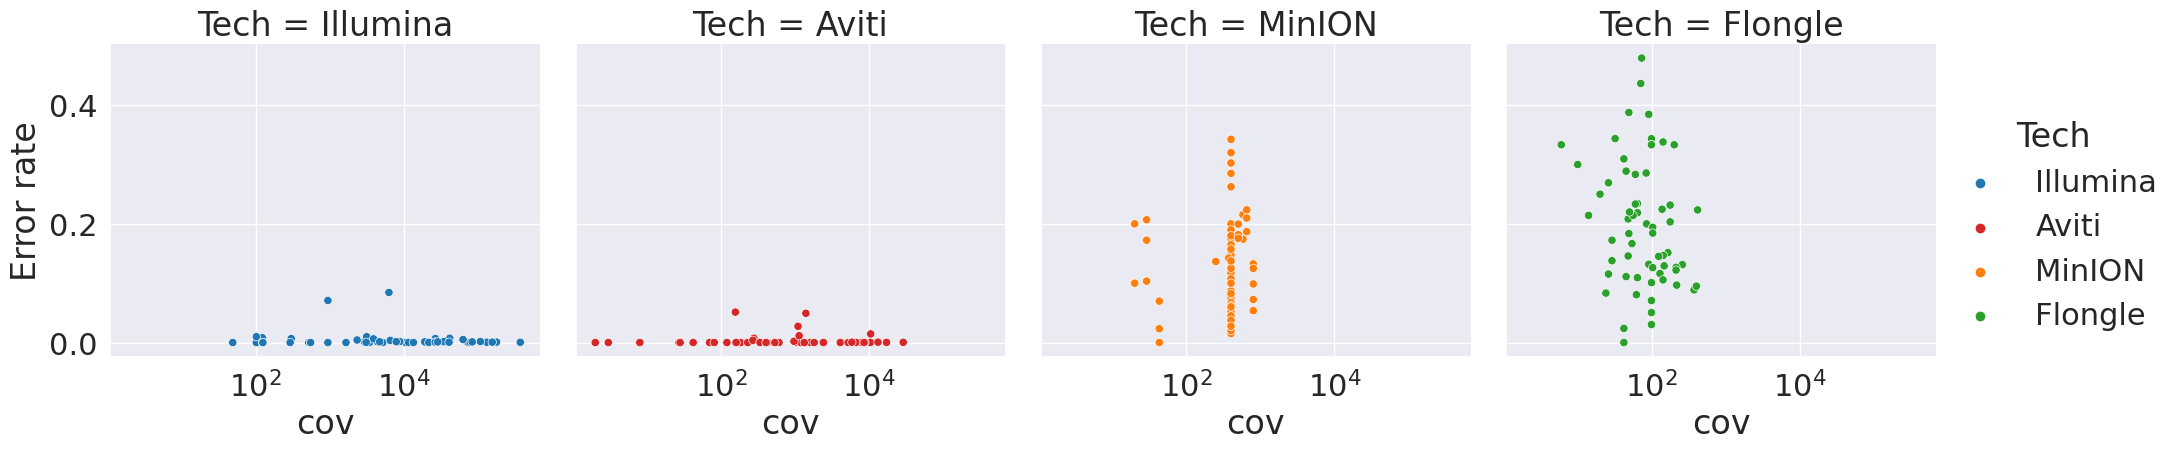

In [51]:
#More detailed plots regarding error rate

df_plot['Amplicon']= df_plot['pos'].map(value_to_primer).astype(str)
df_plot['batch']= df_plot['sample'].map(batch_dic).astype(str)


sns.displot(df_plot, 
             x='Error rate',
            hue = 'Tech',
           col = 'Tech',
           palette = paletteB,
           col_order = lable_order,
           hue_order = lable_order)

e = sns.displot(df_plot, 
             x='Amplicon',
            hue = 'Tech',
           col = 'Tech',
           palette = paletteB,
           col_order = lable_order,
           hue_order = lable_order)

e.set_xticklabels(rotation=90)



f= sns.displot(df_plot, 
            x='Amplicon',
            y='Error rate',
            hue = 'Tech',
           col = 'Tech',
           palette = paletteB,
           col_order = lable_order,
           hue_order = lable_order)

f.set_xticklabels(rotation=90)


g = sns.relplot(df_plot, 
             x='cov',
            y = 'Error rate',
            hue = 'Tech',
           col = 'Tech',
#            kind = 'box',
           palette = paletteB,
           col_order = lable_order,
           hue_order = lable_order)

g.set(xscale="log")


### Variant abundance correlation and Amplicon coverage for spike-in samples

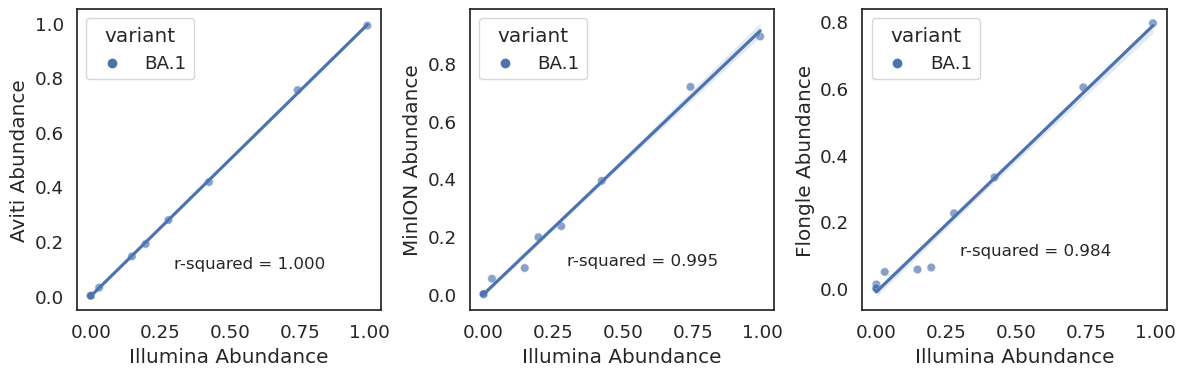

In [75]:
sns.set(font_scale=1.2,style="white")

import scipy.stats as sp

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Adjust subplot layout
plt.subplots_adjust(right=4.0, top=1.3)

# Initialize the index for label_list
label_index = 0

#don't need batch info dispalyed
plot_label_list = ['illumina','aviti','minION','flongle']
lables_clean = ['Illumina','Aviti','MinION','Flongle']

df_plot = deconv_merge_spike.loc[deconv_merge_spike.variant == 'BA.1']

# Iterate through the plot_dfs
for i in range(1, len(plot_label_list)):
    # Illumina needs to be first in list
    r, p = sp.pearsonr(
        df_plot['value' + '_' + plot_label_list[0]],
        df_plot['value' + '_' + plot_label_list[i]]
    )

    # Determine the current subplot's position
#     row = i // 3  # Determine the row position (0 or 1)
#     col = i % 2   # Determine the column position (0 or 1)

    # Create a scatter plot on the current subplot
    sns.scatterplot(
        data=df_plot,
        x='value' + '_' + plot_label_list[0],
        y='value' + '_' + plot_label_list[i],
        hue="variant",
        palette='deep',
        alpha= 0.3,
        ax=axes[i-1],
        legend=True
    )

    # Add the regression line to the scatter plot
    sns.regplot(
        x='value' + '_' + plot_label_list[0],
        y='value' + '_' + plot_label_list[i],
        data=df_plot,
        scatter_kws={"zorder": -1,'alpha':0.001},
        ax=axes[i-1]
    )

    # Add the text with the correlation coefficient to the subplot
    axes[i-1].text(0.3, 0.1, 'r-squared = {:.3f}'.format(r**2), fontsize=12)

    # Set labels for the x and y axes
    axes[i-1].set_xlabel(lables_clean[0] + ' Abundance')
    axes[i-1].set_ylabel(lables_clean[i] + ' Abundance')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
fig.savefig(out_dir + "/AbundanceCorrelation_SpikeIN.png",dpi=600)

Seeem to get better corelation between Naopores in this controlled setting

/scratch/tmp.46991128.anjohn/ipykernel_37631/288162661.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(axes.get_yticks(), size = 20)


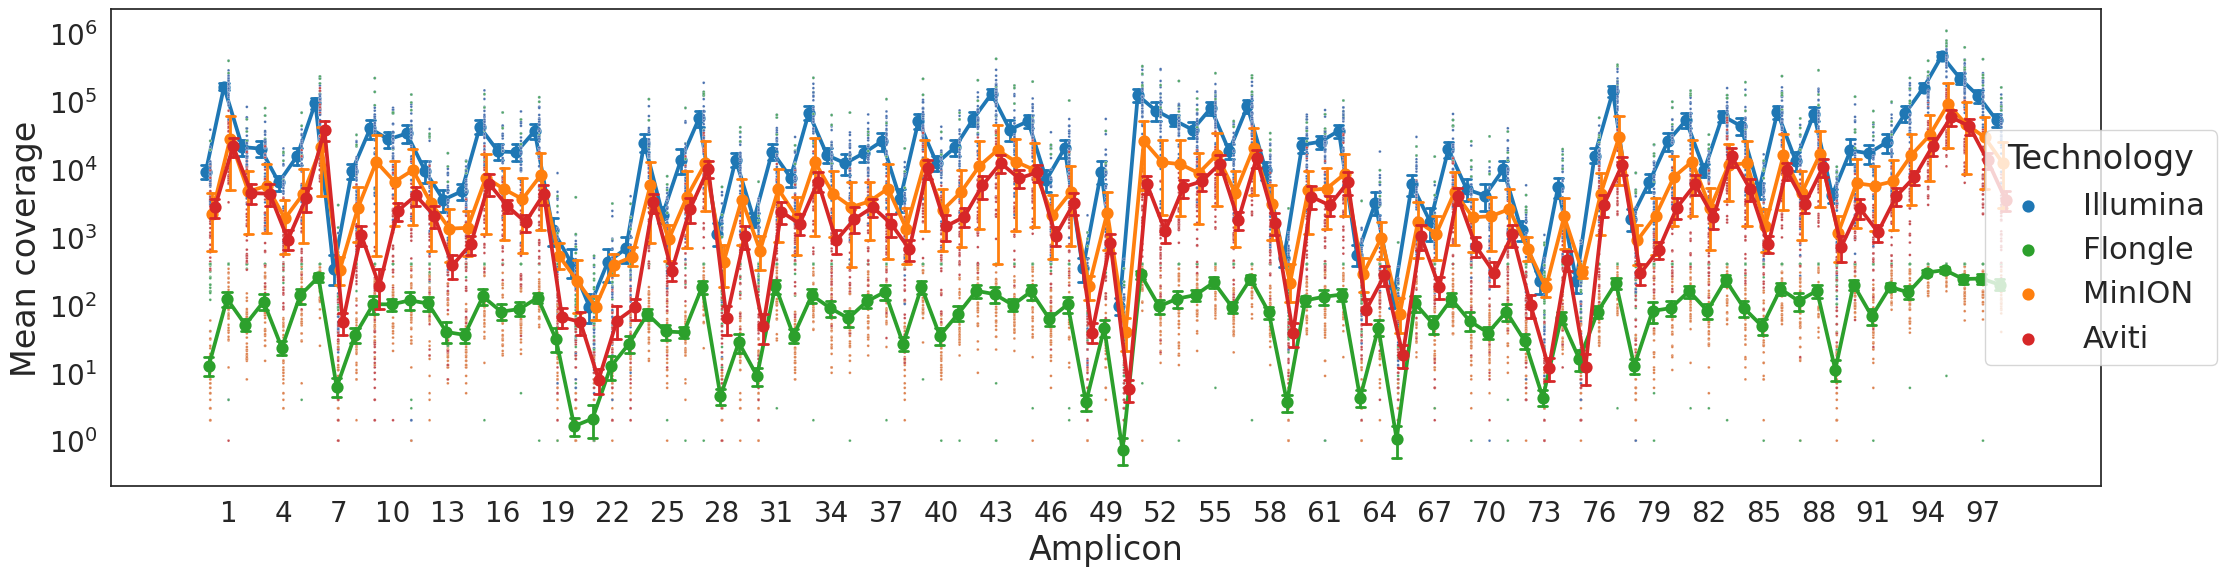

In [96]:
# sns.set_context("notebook", font_scale=1)

fig, axes = plt.subplots(figsize=(30*0.75, 8*0.75)) 

#don't need batch info in dispaly
AmpCov_spike_dfs_all['tech'] = AmpCovNorm_spike_dfs_all['tech'].str.split('_').str[0]
AmpCov_spike_dfs_all['tech'] = AmpCov_spike_dfs_all['tech'].apply(lambda x: x[0].upper() + x[1:] if x else x)


# AmpCov_dfs1 = AmpCov_spike_dfs_all.loc[(AmpCov_spike_dfs_all.tech != 'G4') & 
#                    (AmpCov_spike_dfs_all.tech != 'Aviti')]

AmpCov_dfs1 = AmpCov_spike_dfs_all

# AmpCov_dfs2 = AmpCov_spike_dfs_all.loc[(AmpCov_spike_dfs_all.tech != 'MinION') & 
#                    (AmpCov_spike_dfs_all.tech != 'Flongle')]

sns.pointplot(
    x=AmpCov_dfs1.amplicon,
    y=AmpCov_dfs1.value,
    hue=AmpCov_dfs1.tech, 
#     errorbar=("pi", 50),
    dodge=0.5,
    capsize=0.5,
    errwidth = 2,
    palette = paletteB,
    ax=axes
)


sns.scatterplot(
    x=AmpCov_dfs1.amplicon,
    y=AmpCov_dfs1.value,
    hue=AmpCov_dfs1.tech, 
    s = 4,
    legend=False,
    ax=axes
)

legend = axes.legend(title='Technology',
                        loc='center', 
                        bbox_to_anchor=(1, 0.5),
                        fontsize=22,
                        title_fontsize=24)
        
axes.set_ylabel("Mean coverage",size=24)
axes.set_xlabel("Amplicon",size=24)
axes.set_xticks(np.arange(1, 100, 3))
axes.set_xticklabels(axes.get_xticks(), size = 20)
axes.set_yticklabels(axes.get_yticks(), size = 20)
axes.set_yscale("log")



# sns.pointplot(
#     x=AmpCov_dfs2.amplicon,
#     y=AmpCov_dfs2.value,
#     hue=AmpCov_dfs2.tech, 
# #     errorbar=("pi", 50),
#     dodge=0.5,
#     capsize=0.5,
#     errwidth = 2,
#     palette ={'Illumina': "#1f77b4", 'G4': "#ff0000", 'Aviti': '#800080'},
#     ax=axes[1]
# )


# sns.scatterplot(
#     x=AmpCov_dfs2.amplicon,
#     y=AmpCov_dfs2.value,
#     hue=AmpCov_dfs2.tech, 
#     s = 4,
#     legend=False,
#     palette ={'Illumina': "#1f77b4", 'G4': "#ff0000", 'Aviti': '#800080'},
#     ax=axes[1]
# )

# legend = axes[1].legend(title='Technology', 
#                         loc='center', 
#                         bbox_to_anchor=(1, 0.5),
#                         fontsize=22,
#                         title_fontsize=24)
        
# axes[1].set_ylabel("Mean coverage",size=24)
# axes[1].set_xlabel("Amplicon",size=24)
# axes[1].set_xticks(np.arange(1, 100, 3))
# axes[1].set_xticklabels(axes[1].get_xticks(), size = 20)
# axes[1].set_yticklabels(axes[1].get_yticks(), size = 20)
# axes[1].set_yscale("log")


fig.tight_layout()
fig.show()
fig.savefig(out_dir + "/AmpliconCoverage_spikeIN.png",dpi=600)

# ONT Sequencing Quality

In [ ]:
seq_summary_flongle = pd.read_table(f_seq_summary, compression='gzip')
seq_summary_minION = pd.read_table(m_seq_summary, compression='gzip')

In [ ]:
booleanDictionary = {True: 'TRUE', False: 'FALSE'}
seq_summary_flongle['passes_filtering'] = seq_summary_flongle['passes_filtering'].map(booleanDictionary)
seq_summary_minION['passes_filtering'] = seq_summary_minION['passes_filtering'].map(booleanDictionary)

seq_summary_flongle['start_time'] = pd.to_numeric(seq_summary_flongle['start_time'], errors='coerce')
seq_summary_flongle['duration'] = pd.to_numeric(seq_summary_flongle['duration'], errors='coerce')
seq_summary_flongle['mean_qscore_template'] = pd.to_numeric(seq_summary_flongle['mean_qscore_template'], errors='coerce')
seq_summary_minION['start_time'] = pd.to_numeric(seq_summary_minION['start_time'], errors='coerce')
seq_summary_minION['duration'] = pd.to_numeric(seq_summary_minION['duration'], errors='coerce')
seq_summary_minION['mean_qscore_template'] = pd.to_numeric(seq_summary_minION['mean_qscore_template'], errors='coerce')

seq_summary_flongle["start_timeH"] = seq_summary_flongle.start_time / 3600
seq_summary_flongle["durationH"] = seq_summary_flongle.duration / 3600
seq_summary_flongle.loc[seq_summary_flongle.start_timeH <= 5, 'TimeCategory'] = 'Short Run'
seq_summary_flongle.loc[seq_summary_flongle.start_timeH > 5, 'TimeCategory'] = 'Long Run'
seq_summary_minION["start_timeH"] = seq_summary_minION.start_time / 3600
seq_summary_minION["durationH"] = seq_summary_minION.duration / 3600
seq_summary_minION.loc[seq_summary_minION.start_timeH <= 5, 'TimeCategory'] = 'Short Run'
seq_summary_minION.loc[seq_summary_minION.start_timeH > 5, 'TimeCategory'] = 'Long Run'

In [ ]:
colors = sns.color_palette("tab10")[0:6]
lables = ['Illumina', 'MinION', 'Flongle', 'Aviti', 'G4']
palette = dict(map(lambda i,j : (i,j) , lables,colors))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
fig.tight_layout()

plt.subplots_adjust(wspace=0.3)

sns.histplot(data = seq_summary_minION[['start_timeH','mean_qscore_template', 'passes_filtering']],
             x ='start_timeH', y = 'mean_qscore_template', hue = 'passes_filtering',
             bins= 24, palette = {'FALSE': sns.color_palette()[7], 'TRUE': sns.color_palette()[9]},
             ax=ax[0])

ax[0].set(xlabel='Sequencing time [h]',ylabel='Read quality score', title='MinION')
ax[0].set_xticks(range(0,72,10))

sns.histplot(data = seq_summary_flongle[['start_timeH','mean_qscore_template', 'passes_filtering']],
             x ='start_timeH', y = 'mean_qscore_template',  hue = 'passes_filtering',
             bins= 24, palette = {'FALSE': sns.color_palette()[7], 'TRUE': sns.color_palette()[9]},
             ax=ax[1])

ax[1].set(xlabel='Sequencing time [h]',ylabel='Read quality score', title='Flongle')
ax[1].set_xticks(range(0,24,5))

# fig.savefig(out_dir+"/ONTBaseQuality.png",bbox_inches='tight',dpi=600)